# PTB-XL study
Author: Vincent Lunot  
Date: November 2022  
&nbsp;     
&nbsp;        
We are going to study the PTB-XL dataset, a large publicly available electrocardiography dataset, available at https://physionet.org/content/ptb-xl/1.0.2/.

The structure of this notebook is as follows:
- We will first do a quick study of the metadata.
- Next, we will analyze the signal data, look for anomalies, and develop a simple algorithm to localize the peaks.
- Finally, we will show how to create and train a few simple neural networks on this data.

While many information and tools are available online, we made the choice to study this dataset from scratch, developing ourselves our own simple algorithms. Using existing libraries whenever possible is usually the best practice in production, but our goal here is to get a better understanding of the dataset. That is why we decided to manipulate the data as much as possible.

## 0. Before starting 

First, download the dataset thanks to the `download_data.sh` script available in the `data` directory

Next, execute the cell below to ensure that the plots are correctly displayed:

In [1]:
%matplotlib inline

Check if a GPU is available:

In [2]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
if len(devices) > 0:
    print('A GPU is available!')
else:
    print("Couldn't find any GPU")

A GPU is available!


Some imports for later:

In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os
import matplotlib.pyplot as plt
import wfdb
from IPython.display import Markdown, display
import gc
from mlcm import mlcm

### Global variables

In [4]:
sampling_rate = 500
data_path = '../data/'

## 1. Metadata

### Loading metadata

The following cell, used to load the metadata, is directly extracted from `example_physionet.py` provided with the dataset. 

In [5]:
# load and convert annotation data
Y = pd.read_csv(data_path + 'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(data_path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [6]:
Y.shape

(21801, 44)

There are 21801 samples and 44 metadata information

The metadata columns are:

In [7]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH',
       'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC',
       'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL',
       'diagnostic_superclass'],
      dtype='object')

### Checking for missing data

Let's see if there is any missing data:

In [8]:
Y.isna().sum()

patient_id                          0
age                                 0
sex                                 0
height                          14826
weight                          12379
nurse                            1475
site                               18
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8470
infarction_stadium1             16188
infarction_stadium2             21698
validated_by                     9380
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20202
static_noise                    18541
burst_noise                     21188
electrodes_problems             21771
extra_beats                     19852
pacemaker                       21510
strat_fold                          0
filename_lr                         0
filename_hr 

Some columns have a lot of missing data, for example we don't have the height and weight of many patients.

### Quick variables analysis

Lot of information is available. Below is a table that gives a short description (see original paper):

![Metadata description](images/metadata.png)

Due to time constraints, we are only going to give a look at a few variables, that is `patient_id`, `age`, `sex`, `initial_autogenerated_report` and `validated_by_human`. However, the other variables should be analysed too. For example, all the `Signal Metadata` section could be used to filter out signals with specific problems.

Furthermore, we will also give a look at the `diagnostic_superclass` variable that has been built from `scp_codes`.

#### **patient_id**

Let's check the number of patients:

In [9]:
n_patients = Y.patient_id.nunique()
print(n_patients)

18869


*There are 18869 distinct patients.*

The first 5 IDs are:

In [10]:
Y.patient_id.head()

ecg_id
1    15709.0
2    13243.0
3    20372.0
4    17014.0
5    17448.0
Name: patient_id, dtype: float64

The type is float64 but, as can be seen on the description table above, it was meant to be integers. Since there are IDs, we can expect them to be nonnegative, and given the number of patients, we could expect the IDs to fit on a uint16 size. Let's confirm it is indeed the case:

In [11]:
print(f'smallest id: {Y.patient_id.min()}, biggest id: {Y.patient_id.max()}')

smallest id: 302.0, biggest id: 21797.0


Sanity check to confirm we can cast the IDs to uint16:

In [12]:
all(Y.patient_id == Y.patient_id.astype('uint16'))

True

We can safely convert the values to uint16:

In [13]:
Y.patient_id = Y.patient_id.astype('uint16')

We now look at the number of records per patient:

In [14]:
records_count = Y.patient_id.value_counts()
print(records_count)

9898     10
8304      9
10107     9
17542     9
13145     8
         ..
17525     1
14740     1
20297     1
18508     1
11744     1
Name: patient_id, Length: 18869, dtype: int64


*The patient with the most records is patient 9898 with 10 records*.

In [15]:
(records_count == 1).mean()

0.8880173830091684

*Approximately 89% of the patients have only one record.*

#### **age**

Let's give a look at the ages:

In [16]:
Y.age

ecg_id
1         56.0
2         19.0
3         37.0
4         24.0
5         19.0
         ...  
21833     67.0
21834    300.0
21835     59.0
21836     64.0
21837     68.0
Name: age, Length: 21801, dtype: float64

In [17]:
Y.age.describe()

count    21801.000000
mean        62.769781
std         32.307421
min          2.000000
25%         50.000000
50%         62.000000
75%         72.000000
max        300.000000
Name: age, dtype: float64

Ages range from 2 to 300. We could be surprised by the 300 value, but it comes from standards. Indeed, from the dataset description:
```
The date of birth only as age at the time of the ECG recording, where ages of more than 89 years appear in the range of 300 years in compliance with HIPAA standards.
```

Let's check that ages indeed jump from 89 to 300:

In [18]:
Y.age[Y.age > 89].unique()

array([300.])

As for the patient IDs, we will also convert the ages to integers:

In [19]:
all(Y.age == Y.age.astype('uint16'))

True

In [20]:
Y.age = Y.age.astype('uint16')

Finally, let's plot a histogram to visualize the age distribution:

<AxesSubplot:>

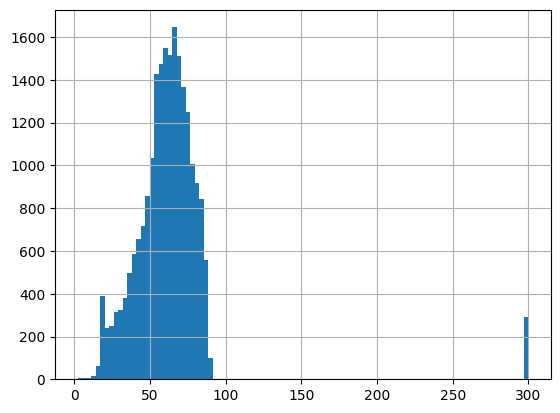

In [21]:
Y.age.hist(bins=100)

#### **sex**

Let's give a look at the sex column:

In [22]:
Y.sex

ecg_id
1        1
2        0
3        1
4        0
5        1
        ..
21833    1
21834    0
21835    1
21836    1
21837    0
Name: sex, Length: 21801, dtype: int64

From the description table, we see that 0 means male and 1 female.

In [23]:
counts = Y.sex.value_counts()
print(counts)

0    11356
1    10445
Name: sex, dtype: int64


In [24]:
print(f'The male percentage is: {100 * counts[0] / len(Y):.2f}%') 

The male percentage is: 52.09%


#### **initial_autogenerated_report**

In [25]:
Y.initial_autogenerated_report

ecg_id
1        False
2        False
3        False
4        False
5        False
         ...  
21833     True
21834     True
21835     True
21836     True
21837     True
Name: initial_autogenerated_report, Length: 21801, dtype: bool

In [26]:
Y.initial_autogenerated_report.mean()

0.3125086005229118

*Approximately 31% of the reports are initial autogenerated reports.*

#### **validated_by_human**

In [27]:
Y.validated_by_human

ecg_id
1        True
2        True
3        True
4        True
5        True
         ... 
21833    True
21834    True
21835    True
21836    True
21837    True
Name: validated_by_human, Length: 21801, dtype: bool

In [28]:
Y.validated_by_human.mean()

0.7365717168937205

*Approximately 74% of the data was validated by human.*

Let's see how what percentage of autogenerated reports were not validated by human:

In [29]:
print(f'{((Y.initial_autogenerated_report & ~Y.validated_by_human).mean()):.2f}% of the reports are initial autogenerated reports that have not been validated by human.')

0.26% of the reports are initial autogenerated reports that have not been validated by human.


#### **diagnostic_superclass**

Finally, let's check the diagnostic superclass:

In [30]:
Y['diagnostic_superclass']

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21801, dtype: object

Since each value is a list, we can expect to sometimes have multiple diagnostics. We will take the length of the lists to have the number of diagnostics.

In [31]:
diagnostic_len = Y['diagnostic_superclass'].apply(len)

In [32]:
diagnostic_len.describe()

count    21801.000000
mean         1.274116
std          0.603046
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: diagnostic_superclass, dtype: float64

We see we have from 0 to 4 diagnostics.

In [33]:
diagnostic_len_count = diagnostic_len.value_counts()
print(diagnostic_len_count)

1    16248
2     4072
3      919
0      405
4      157
Name: diagnostic_superclass, dtype: int64


The most common is one diagnostic only.

Text(0, 0.5, 'Number of patients')

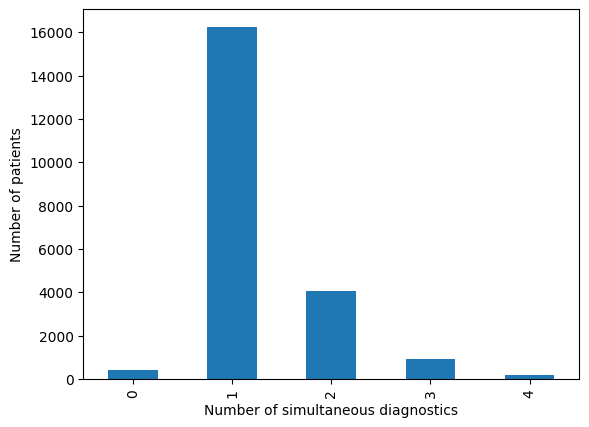

In [34]:
diagnostic_len_count.sort_index().plot.bar()
plt.xlabel('Number of simultaneous diagnostics')
plt.ylabel('Number of patients')

Let's now see the distribution of diagnostics:

In [35]:
all_diagnostics = Y.diagnostic_superclass.aggregate(sum)

In [36]:
all_diagnostics_count = pd.Series(all_diagnostics).value_counts()
print(all_diagnostics_count)

NORM    9517
MI      5473
STTC    5237
CD      4901
HYP     2649
dtype: int64


Text(0, 0.5, 'Number of patients')

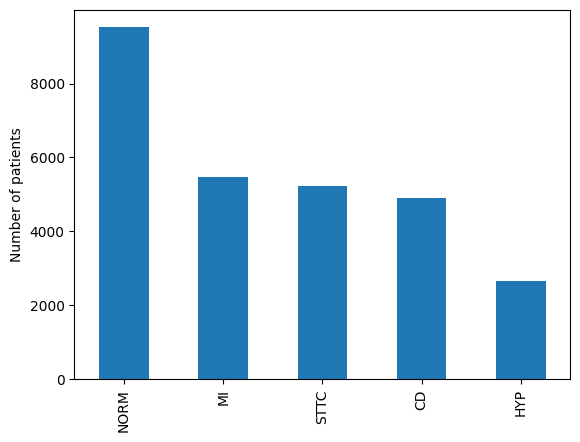

In [37]:
all_diagnostics_count.plot.bar()
plt.ylabel('Number of patients')

We are now going to look at the diagnostics per age groups. We create 5 groups:
- less than 25 years old
- between 25 and 50 years old
- between 50 and 62 years old
- between 62 and 72 years old
- more than 72 years old

Note that the values 50, 62  and 72 are coming from the age percentiles (see above). Having a single group for ages below 50 years seemed to be a bit too rough, so we decided to divide it in two groups (less than 25 and between 25 and 50).

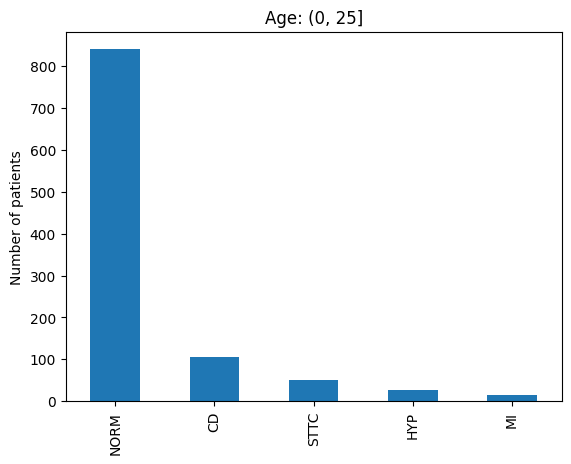

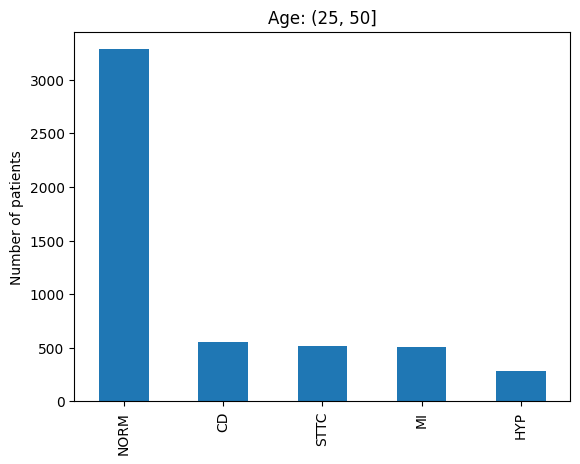

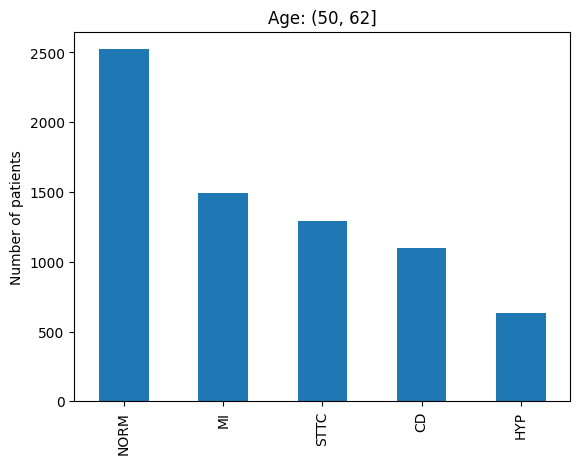

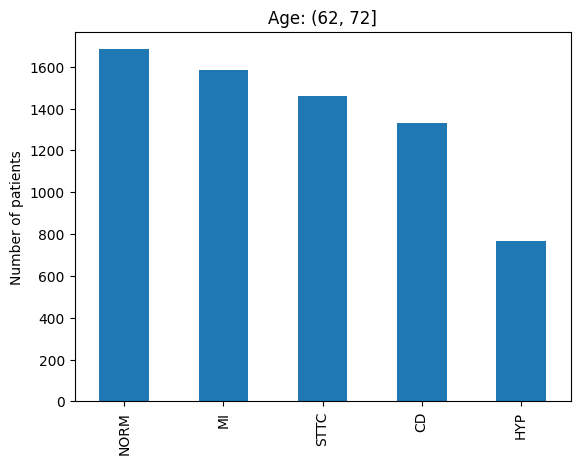

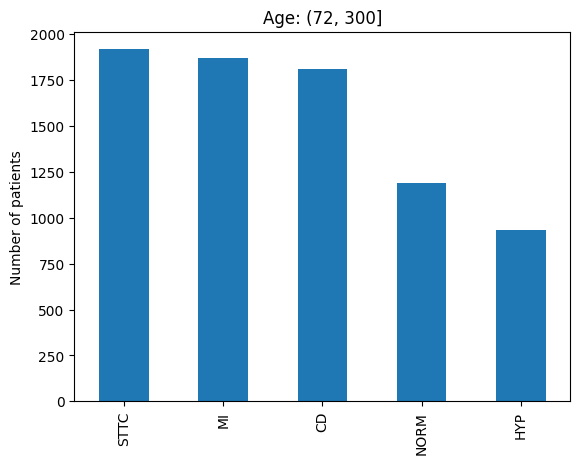

In [38]:
diagnostics_per_age_groups = Y.groupby(pd.cut(Y['age'], [0, 25, 50, 62, 72, 300])).diagnostic_superclass.aggregate(sum)
for i, row in enumerate(diagnostics_per_age_groups):
    pd.Series(row).value_counts().plot.bar()
    plt.title(f'Age: {diagnostics_per_age_groups.index[i]}')
    plt.ylabel('Number of patients')
    plt.show()

We can see that the distributions of diagnostics by age groups are really different.

### Metadata conclusion

As noted before, due to time constraints, we have only checked a small part of the metadata. Looking at all the metadata, and crossing multiple information such as age, height, weight (or body mass index) and pathologies would probably lead to interesting insights. Furthermore, looking for detailed explanations (particularly for all the specific medical terms and methods) would also be extremely important for any future work.

Note: we have noticed that the data types are not enforced by the code used to load the metadata. We should add the types in the loading code (inside the call to `pandas.read_csv`, using the `dtype` argument) to ensure that we always use the same types whenever we work on this dataset (and its future versions).

## Signal

We will now study the signal. To load as well as display the signal, we will use the Python waveform-database (WFDB) package. The documentation is available at: https://wfdb.readthedocs.io/.

### Loading signal data

The code below is taken from `example_physionet.py` provided with the dataset.

In [39]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# Load raw signal data
X = load_raw_data(Y, sampling_rate, data_path)

Let's display some records using `wfdb`:

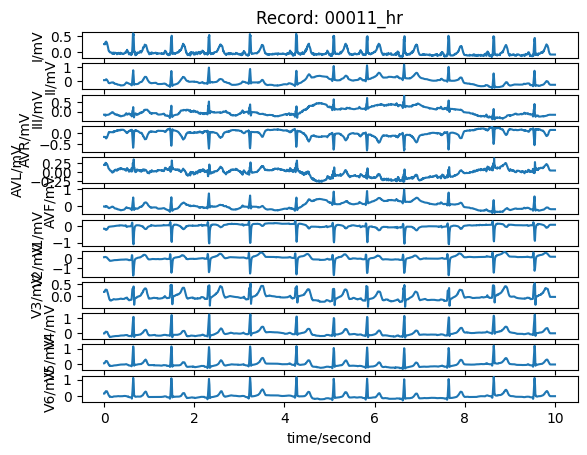

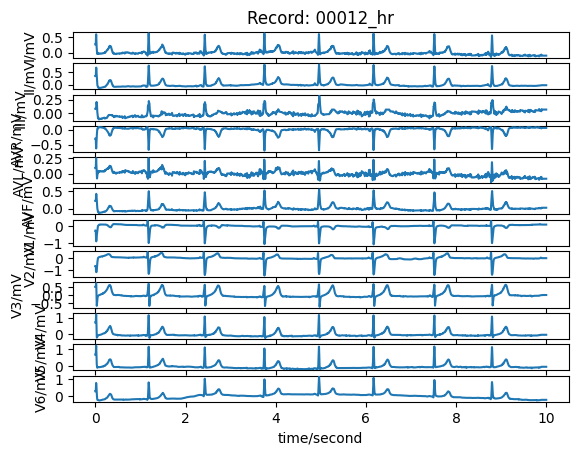

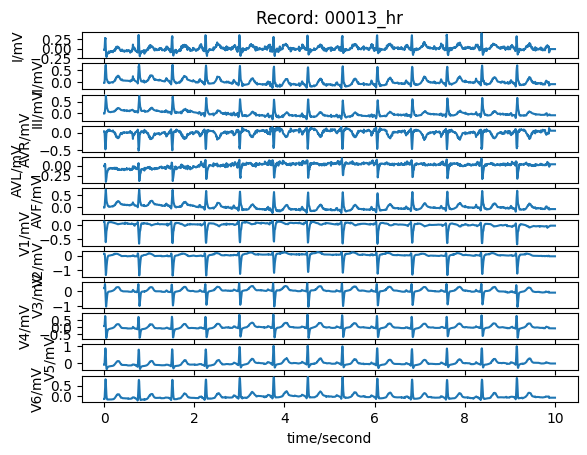

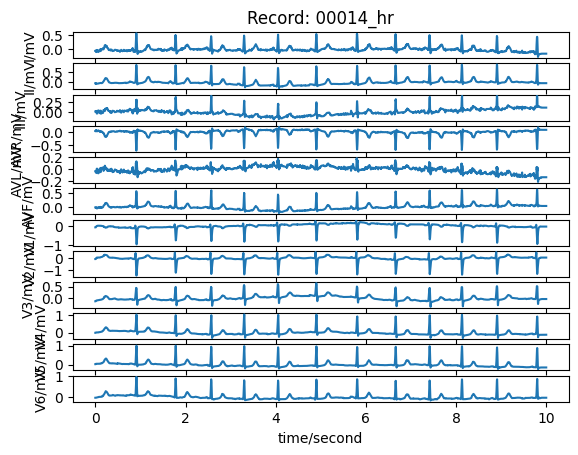

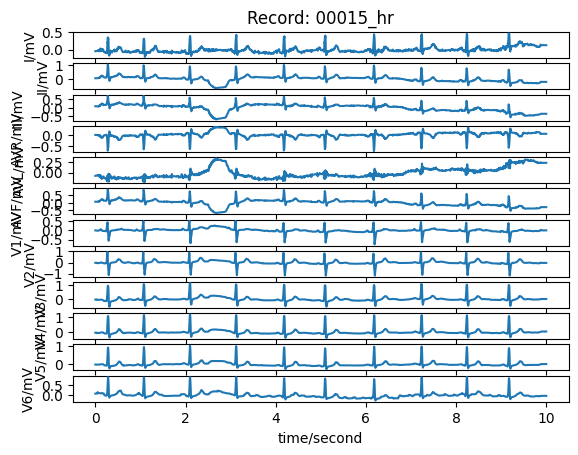

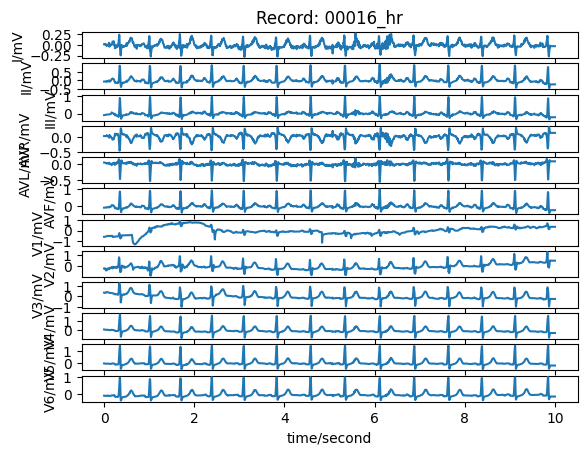

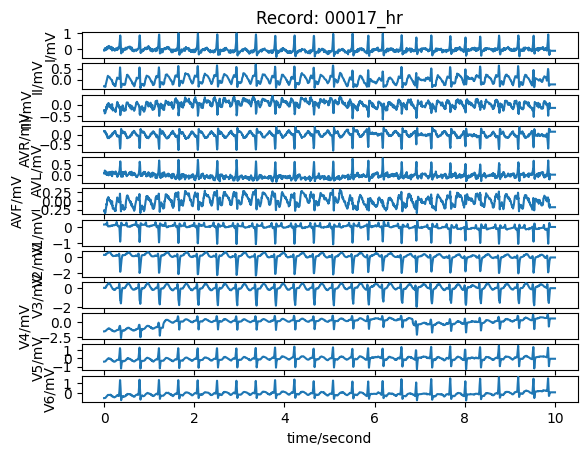

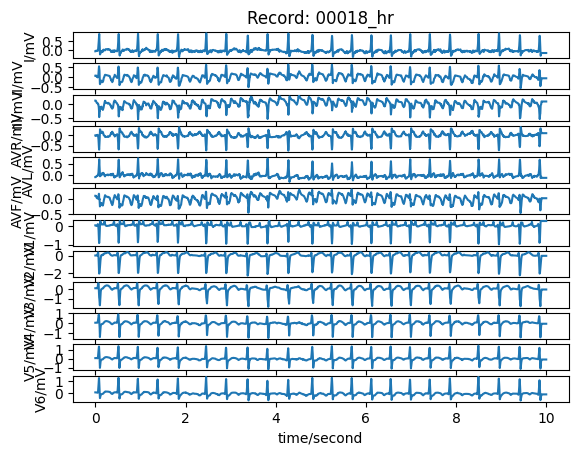

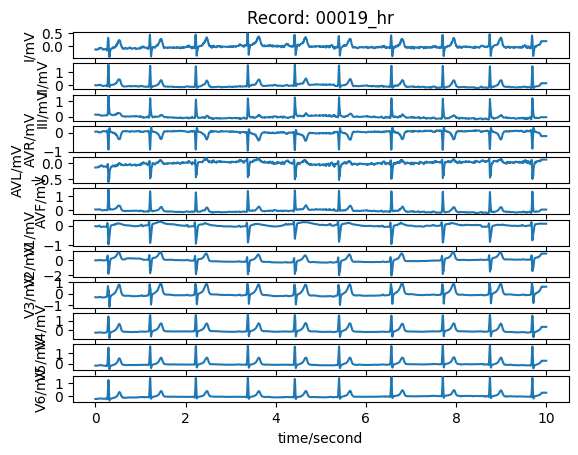

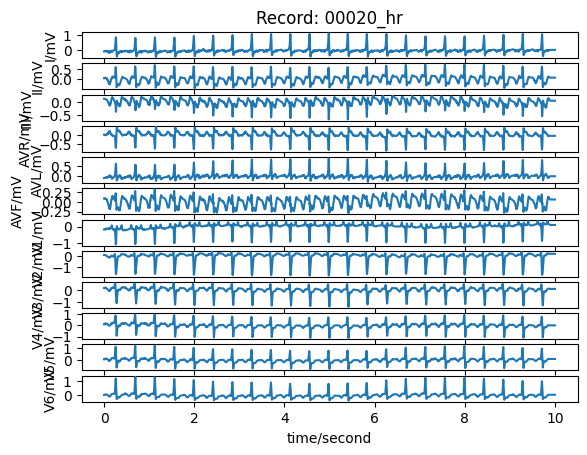

In [40]:
for f in Y.filename_hr.iloc[10:20]:
    record = wfdb.rdrecord(os.path.join(data_path, f))
    wfdb.plot_wfdb(record=record)

While the signals are all 10 seconds long, they look relatively diverse. For example record 00012 has 8 heartbeats and record 00020 has 23. Some signals look less 'regular' such as 00015 who has some 'bumps'.

### Signal amplitudes

On the above plots, the signals seem to always be between -1 and 1. Let's see if it is always the case.

In [41]:
maxima = np.abs(X).max(axis=(1,2))
maxima.shape

(21801,)

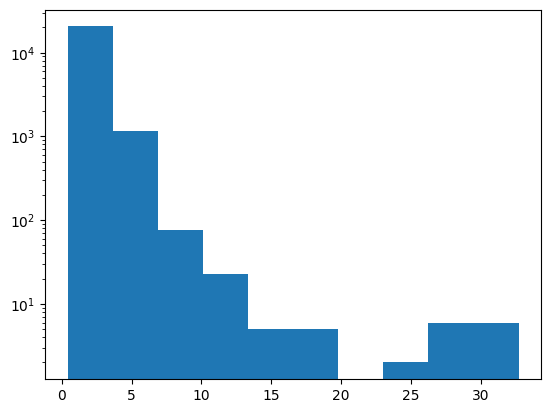

In [42]:
plt.hist(maxima)
plt.yscale('log')

While most of the records have small values, we see that there are a few records that have some very high values.

Let's check the record with the highest maximum.

In [43]:
idx = maxima.argmax()
X[idx].max()

32.716

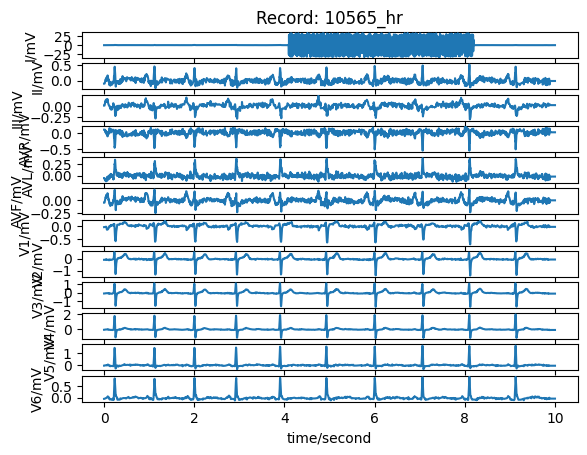

In [44]:
f = Y.filename_hr.iloc[idx]
record = wfdb.rdrecord(os.path.join(data_path, f))
wfdb.plot_wfdb(record=record)

The first signal of this record is really surprising. Let's look at it specifically:

Text(0.5, 1.0, 'Record: 10565_hr, Electrode: I')

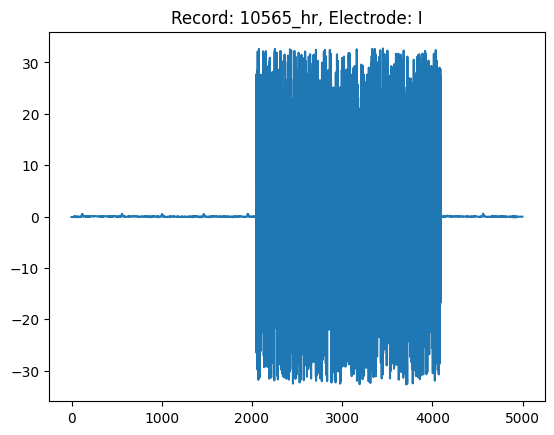

In [45]:
plt.plot(X[idx][:, 0])
plt.title(f"Record: {Y.filename_hr.iloc[idx].split('/')[-1]}, Electrode: I")

We can assume that there was probably a problem during recording. When we studied the metadata, we saw that there is a section linked to signal information. Let's check the metadata of this record:

In [46]:
Y.iloc[idx]

patient_id                                                                  17505
age                                                                            62
sex                                                                             0
height                                                                        NaN
weight                                                                        NaN
nurse                                                                         0.0
site                                                                          0.0
device                                                                 CS100    3
recording_date                                                1993-07-18 10:47:16
report                          sinusrhythmus p-sinistrocardiale lagetyp norma...
scp_codes                             {'NDT': 100.0, 'LAO/LAE': 100.0, 'SR': 0.0}
heart_axis                                                                    MID
infarction_stadi

Note that the field validated_by_human is False and it is an initial autogenerated report, so we should be particularly careful about this record. Most of the signal metadata fields are empty, except for static_noise that has a 'alles' value (it means all in German). The noise is particularly strong.

We are now going to look at a few more records with high absolute maximum. Let's select the top 10 records indices:

In [47]:
high_values_indices = maxima.argsort()[::-1][:10]

We have already checked the first record, so we will now focus on the next nine ones. We are only displaying the signal of the electrode with highest maximum:

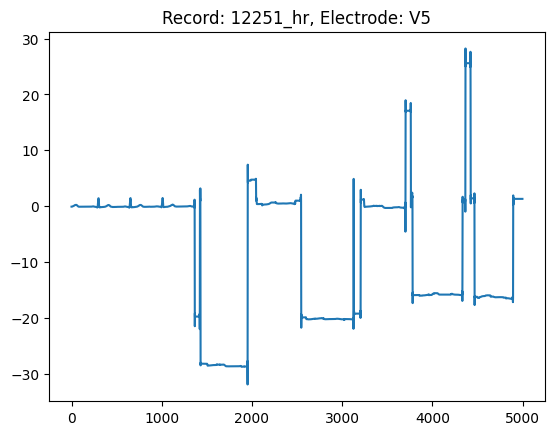

baseline_drift         V5,  
static_noise             NaN
burst_noise              NaN
electrodes_problems      NaN
extra_beats              NaN
pacemaker                NaN
Name: 12251, dtype: object
31.896


---

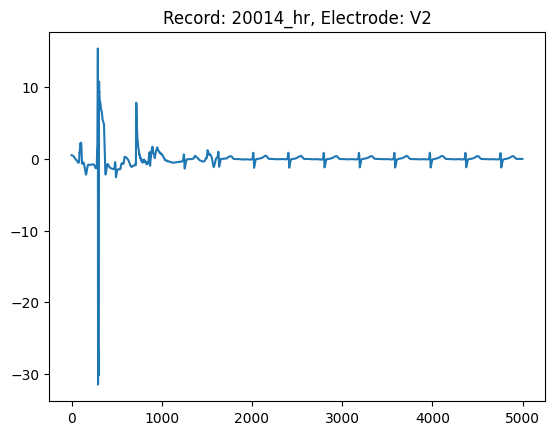

baseline_drift                     NaN
static_noise                       NaN
burst_noise                      V1-V4
electrodes_problems                NaN
extra_beats            VES,SVES2,V2,V3
pacemaker                          NaN
Name: 20014, dtype: object
31.453


---

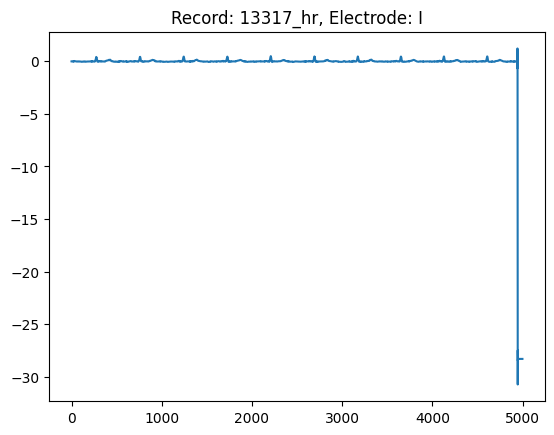

baseline_drift         NaN
static_noise           NaN
burst_noise            NaN
electrodes_problems    NaN
extra_beats            NaN
pacemaker              NaN
Name: 13317, dtype: object
30.728


---

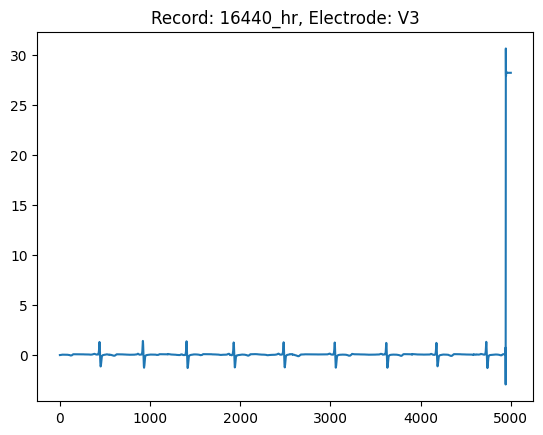

baseline_drift         NaN
static_noise           NaN
burst_noise            NaN
electrodes_problems    NaN
extra_beats            NaN
pacemaker              NaN
Name: 16440, dtype: object
30.669


---

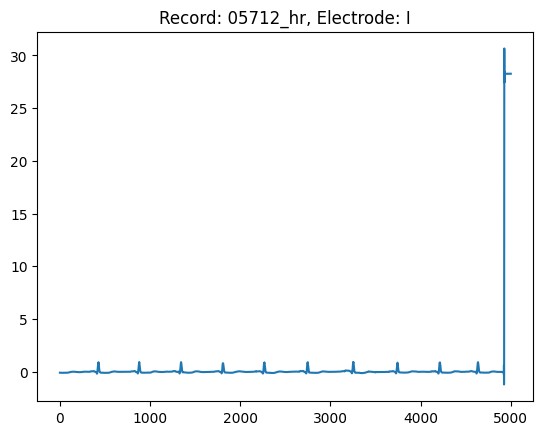

baseline_drift         NaN
static_noise           NaN
burst_noise            NaN
electrodes_problems    NaN
extra_beats            NaN
pacemaker              NaN
Name: 5712, dtype: object
30.658


---

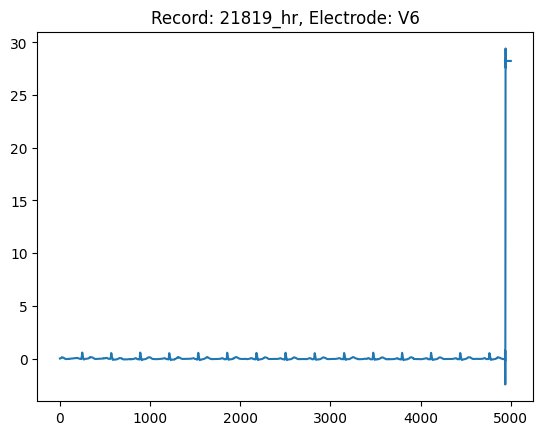

baseline_drift         NaN
static_noise           NaN
burst_noise            NaN
electrodes_problems    NaN
extra_beats            NaN
pacemaker              NaN
Name: 21819, dtype: object
29.421


---

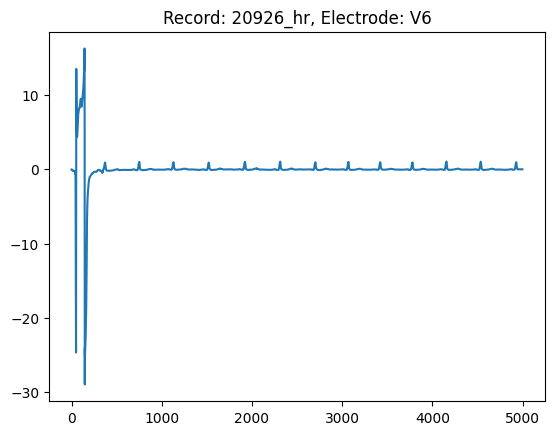

baseline_drift           NaN
static_noise             NaN
burst_noise            V3-V6
electrodes_problems      NaN
extra_beats             1,V6
pacemaker                NaN
Name: 20926, dtype: object
28.952


---

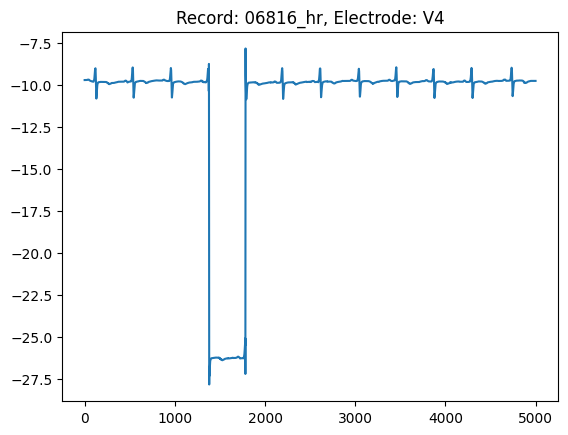

baseline_drift          , AVL,V5
static_noise                 NaN
burst_noise                  NaN
electrodes_problems          NaN
extra_beats                  NaN
pacemaker                    NaN
Name: 6816, dtype: object
27.817


---

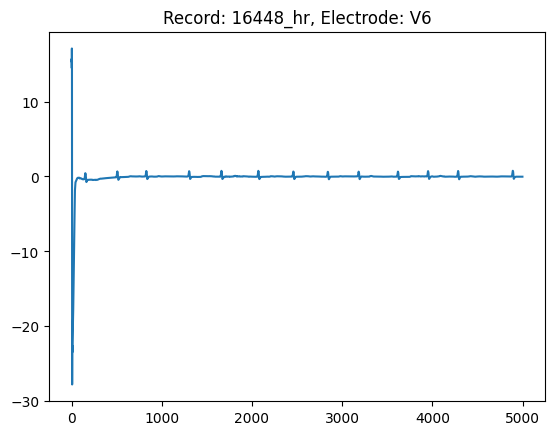

baseline_drift             NaN
static_noise               NaN
burst_noise                NaN
electrodes_problems        NaN
extra_beats            2,V5,V6
pacemaker                  NaN
Name: 16448, dtype: object
27.767


---

In [48]:
signal_metadata_columns = ['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker']
electrodes = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
for i in high_values_indices[1:]:
    argmax = np.abs(X[i]).max(axis=0).argmax()
    plt.plot(X[i][:, argmax])
    plt.title(f"Record: {Y.filename_hr.iloc[i].split('/')[-1]}, Electrode: {electrodes[argmax]}")
    plt.show()
    print(Y.iloc[i][signal_metadata_columns])
    print(np.abs(X[i][:, argmax]).max())
    display(Markdown('---'))

We see that for some of these signals, the big change of value has been annotated in the signal metadata. However for some others, there is no annotation. In particular, for all the jumps at the end of the signal in the records 13317, 16440, 05712 and 21819, there is no annotation. This problem should be analyzed more in-depth, to decide for example if all the records should be kept or some of them removed. At the moment, we will just do a very rough cleaning, by removing the records that have the highest absolute values: we will remove all the records above the 95 percentile. Furthermore, since there are just a few records annotated with burst_noise or electrodes_problems, we will also remove these records.

In [49]:
selection = Y.burst_noise.isna() & Y.electrodes_problems.isna() & (maxima < np.percentile(maxima, 95))

In [50]:
Y_selec = Y.loc[selection]
X_selec = X[selection]
print(len(X_selec))

20169


After this very rough cleaning, our dataset now has 20169 samples.

### Localizing QRS-complexes

From Wikipedia (https://en.wikipedia.org/wiki/QRS_complex):  

<blockquote>
The QRS complex is the combination of three of the graphical deflections seen on a typical electrocardiogram (ECG or EKG). It is usually the central and most visually obvious part of the tracing. It corresponds to the depolarization of the right and left ventricles of the heart and contraction of the large ventricular muscles.

<div style="max-width:20%;margin-left: 0; margin-right: 0; text-align: center;">
  <figure>
    <img src="images/qrs.png"/>
    <figcaption>Schematic representation of normal sinus rhythm showing standard wave, segments, and intervals</figcaption>
  </figure>
</div>

Not every QRS complex contains a Q wave, an R wave, and an S wave. By convention, any combination of these waves can be referred to as a QRS complex. However, correct interpretation of difficult ECGs requires exact labeling of the various waves. Some authors use lowercase and capital letters, depending on the relative size of each wave. For example, an Rs complex would be positively deflected, while an rS complex would be negatively deflected. If both complexes were labeled RS, it would be impossible to appreciate this distinction without viewing the actual ECG.

<div style="max-width:20%;margin-left: 0; margin-right: 0; text-align: center;">
  <figure>
    <img src="images/qrs_nomenclature.png"/>
    <figcaption>Various QRS complexes with nomenclature.</figcaption>
  </figure>
</div>
</blockquote>

From our understanding, QRS-complexes are always located where the biggest peaks in the signal are (at the possible exception of a very located strong noise). Since QRS-complexes can have many forms (see nomenclature above), we will focus first on localizing the point of the complex with highest amplitude. Localizing the QRS-complexes can have multiple applications, such as computing the heart rate.

Many methods, that are more or less robust, have been published to localize the QRS-complex, and the Pan-Tompkins method is very commonly used. We will now try to develop our own very naive method below.

Let's plot the first record of our dataset:

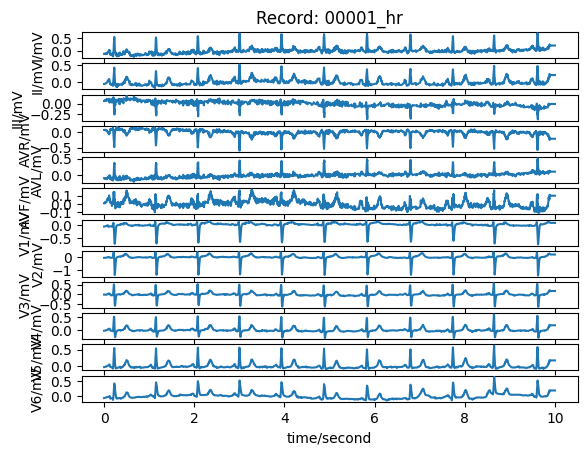

In [51]:
record = wfdb.rdrecord(os.path.join(data_path, Y_selec.filename_hr.iloc[0]))
wfdb.plot_wfdb(record=record)

We can notice that:
- the big peaks appear in each electrode signal and are synchronous,
- some peaks have positive values while some other have negative values,
- for some signals, the peaks are more difficult to guess (e.g. for the 6th electrode above)

To make the peaks very visible, we could try to combine the 12 signals. However not all the signals stay centered on zero for the whole 10 seconds. We should therefore try first to center the signal around zero, that is to remove any drift. 
To that purpose, we will remove the median value of a sliding window from the signal (we don't use a moving average because the value of the peaks can be way higher than the other values):

In [52]:
def remove_drift(signal, padding=50):
    # signal: a 12 channels signal
    # padding: median sliding window has a length of 2 * padding
    assert signal.shape[-1] == 12
    padded_signal = np.pad(signal, ((padding, padding), (0, 0)), mode='reflect')
    moving_median = np.array([np.median(padded_signal[i : i+2*padding], axis=0) for i in range(len(signal))])
    return signal - moving_median

Let's see the result of this function on the first record:

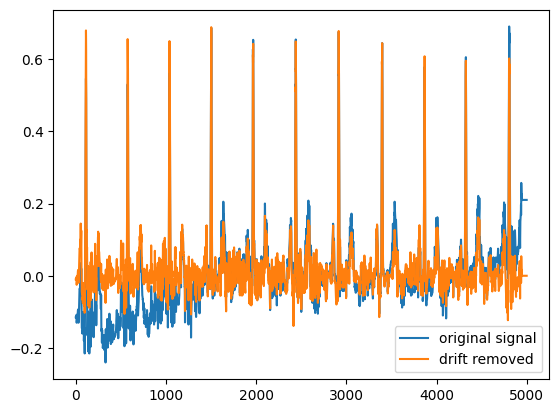

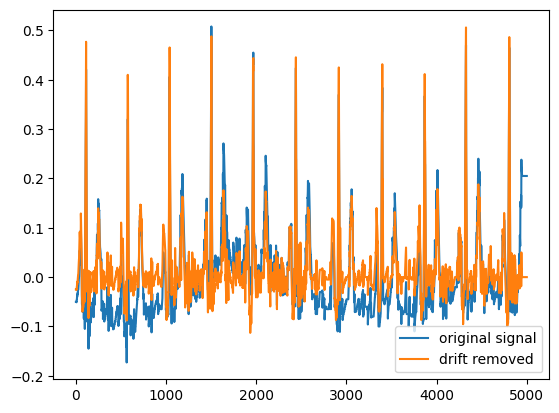

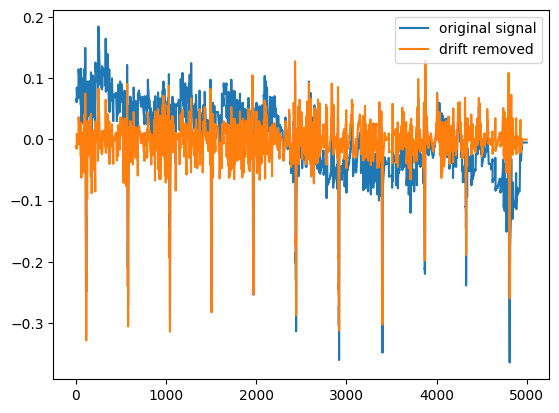

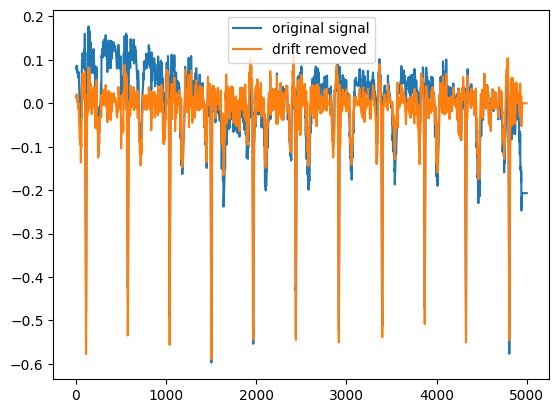

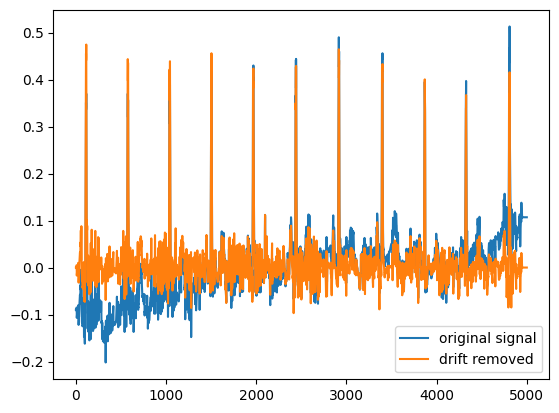

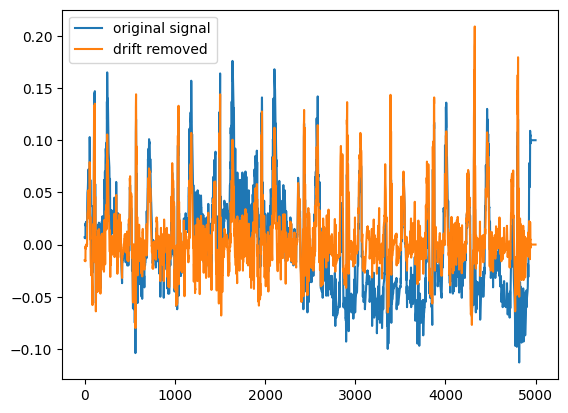

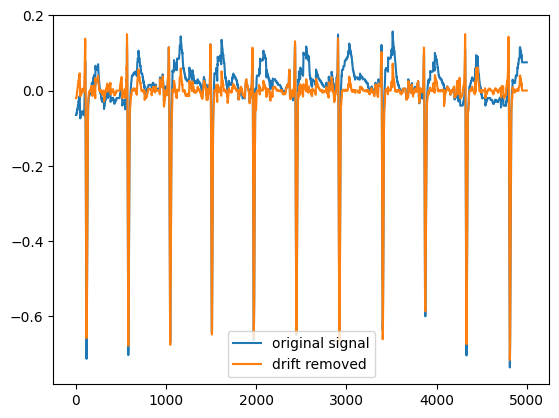

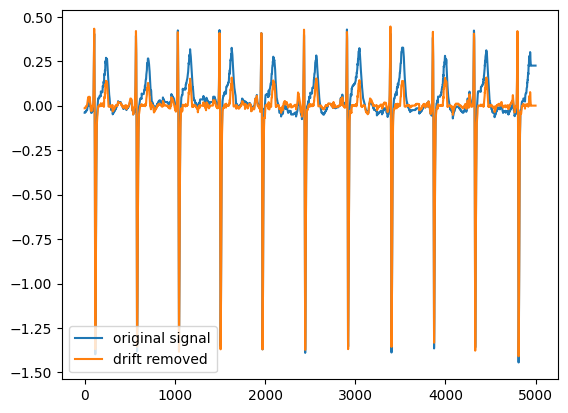

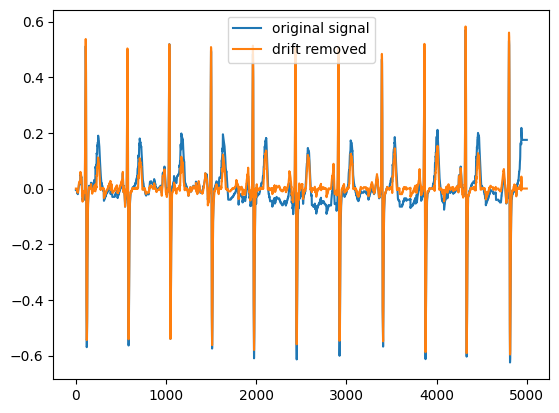

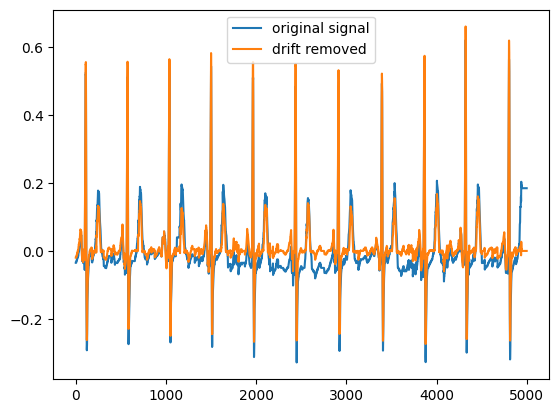

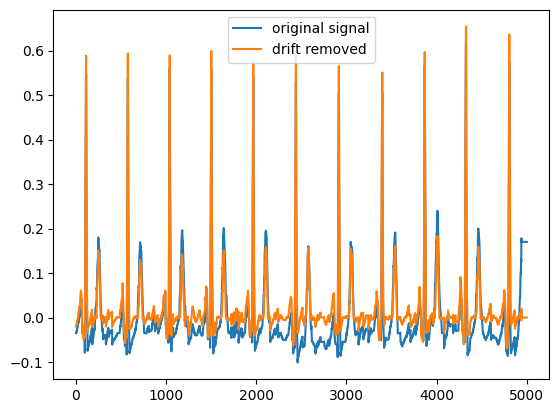

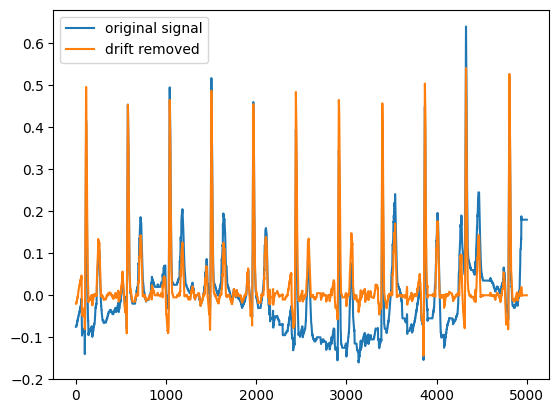

In [53]:
signal = X_selec[0]
drift_removed = remove_drift(signal)
for i in range(12):
    plt.plot(signal[:, i], label='original signal')
    plt.plot(drift_removed[:, i], label='drift removed')
    plt.legend()
    plt.show()

Now that we have removed the drifts, we can combine the signals from the different electrodes. We could simply sum the different signals and next take the absolute value to look for peaks with big amplitude. But since for different leads, the peaks signs are not the same, depending on the exact location of these peaks, it could be better to first take the absolute value and next the sum.  
Below is the result for these two ways of combining the signals, applied to the same record as above:

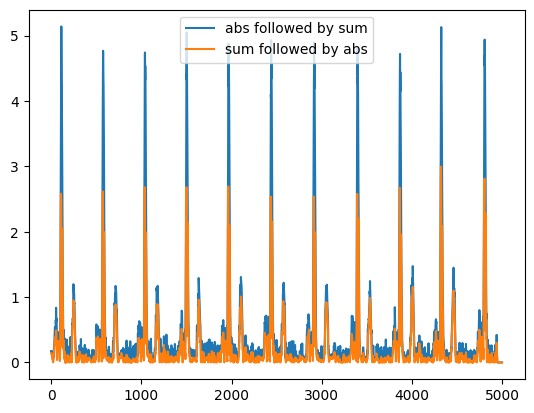

In [54]:
plt.plot(np.sum(np.abs(drift_removed), axis=1), label='abs followed by sum')
plt.plot(np.abs(np.sum(drift_removed, axis=1)), label='sum followed by abs')
plt.legend()

We see that it will be easier to localize the peaks if we take the absolute value first and next take the sum, since the difference between the main peaks and the secondary peaks becomes more obvious. We plot again this combined signal, as well as a threshold at the 98% percentile:

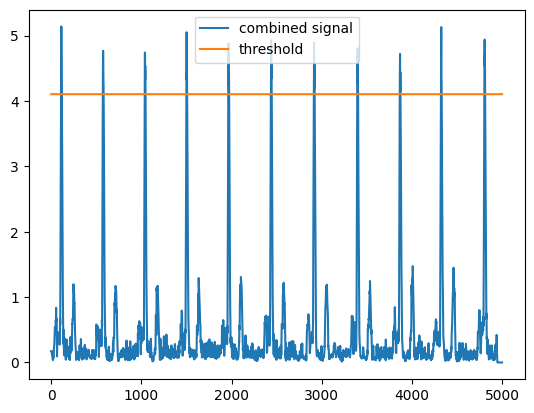

In [55]:
accumulated = np.sum(np.abs(drift_removed), axis=1)
plt.plot(accumulated, label='combined signal')
threshold = np.percentile(accumulated, 98)
plt.plot([threshold] * len(accumulated), label='threshold')
plt.legend()

Now, we can a boolean array of the points that are above the threshold. We next want to get the beginning and end of each interval with True value. That can be obtained easily by doing the difference between a value and its preceding value:

In [56]:
diff = np.diff((accumulated > threshold).astype(int), prepend=0, append=0)

Differences equal to 1 happen at the beginning of each interval and differences equal to -1 at the end of each interval. We check below that the values are indeed above the threshold on the first interval and below outside of the interval:

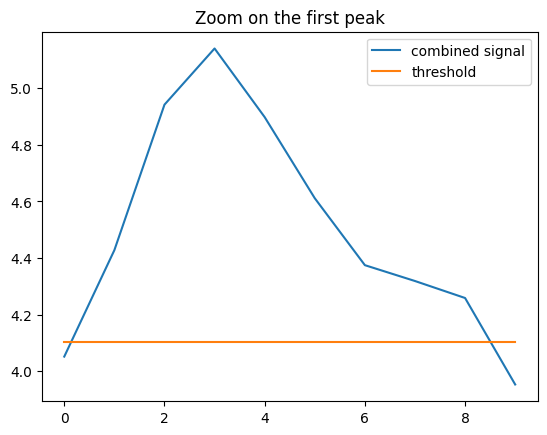

In [57]:
for start, end in zip(np.nonzero(diff == 1)[0], np.nonzero(diff == -1)[0]):
    plt.plot(accumulated[start - 1 : end + 1], label='combined signal')
    plt.plot([threshold] * (end - start + 2), label='threshold')
    plt.title('Zoom on the first peak')
    plt.legend()
    break

By combining the ideas above we get the following naive algorithm:

In [58]:
def naive_qrs_complex_max_localizer(signal, percentile=97, tolerance=20, padding=50):
    """Find the highest amplitude point of each QRS-complex
    
    Returns: an array of the indices of these points, the size of the array 
    being equal to the number of QRS-complexes detected.
    
    Args:
      signal: a 12 channels signal
      percentile: used for thresholding the signal
      tolerance: minimum space allowed between two peaks intervals
      padding: median sliding window has a length of 2 * padding
    """
    assert signal.shape[-1] == 12
    drift_removed = remove_drift(signal, padding)
    accumulated = np.sum(np.abs(drift_removed), axis = 1)
    threshold = np.percentile(accumulated, percentile)
    diff = np.diff((accumulated > threshold).astype(int), prepend=0, append=0)
    starts = np.nonzero(diff == 1)[0]
    ends = np.nonzero(diff == -1)[0]
    # We now remove any end followed by a start if they are close to each other 
    # That means the signal is below the threshold for just a few points
    indices = np.nonzero(starts[1:] - ends[:-1] < tolerance)
    for i in indices:
        starts = np.delete(starts, i + 1)
        ends = np.delete(ends, i)
    peaks_indices = []
    for start, end in zip(starts, ends):
        peaks_indices.append(start + accumulated[start:end].argmax())
    # If we don't want to look for the argmax, we can simply take the 
    # middle points of the intervals:
    # peaks_indices = (starts + ends - 1) // 2
    return np.array(peaks_indices)

We now plot the localized QRS-complexes highest amplitude points for the first record. Remember that we combine the electrode signals to compute the peaks, so that the peaks will not always be exactly at the maximum of the peak for each electrode signal. 

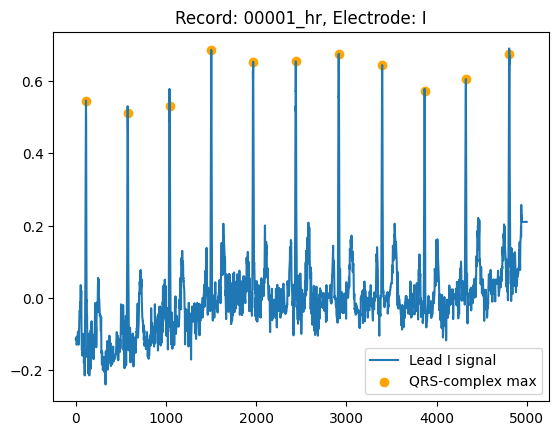

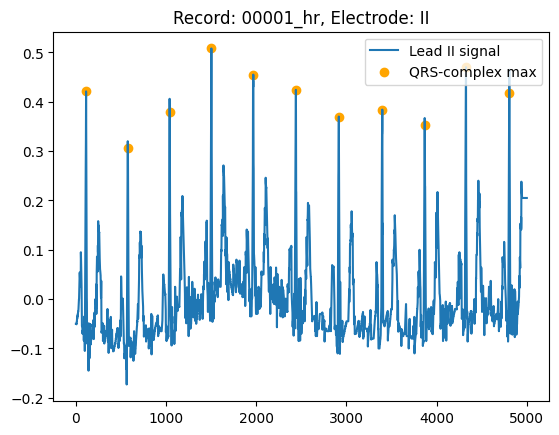

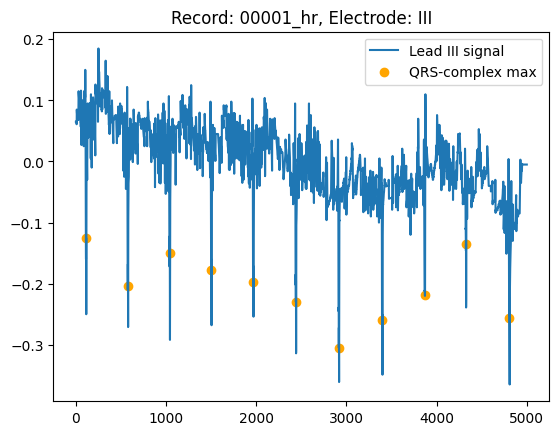

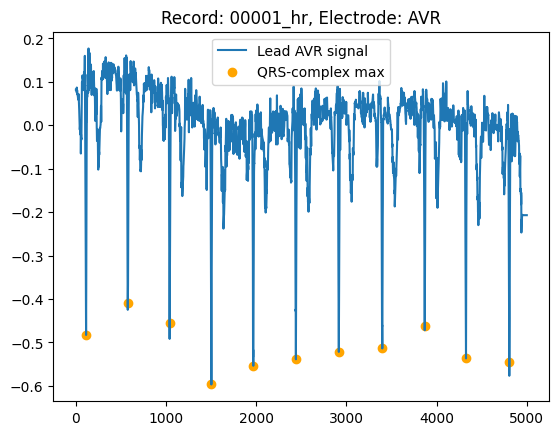

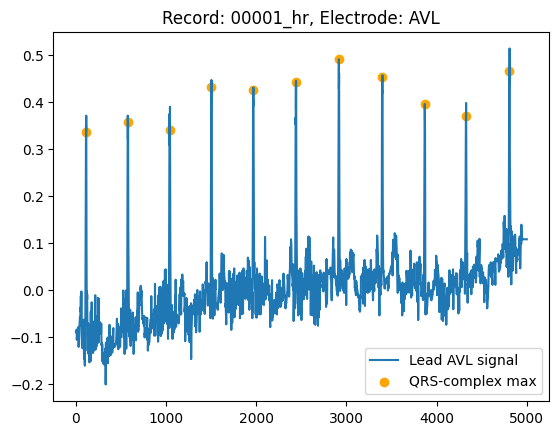

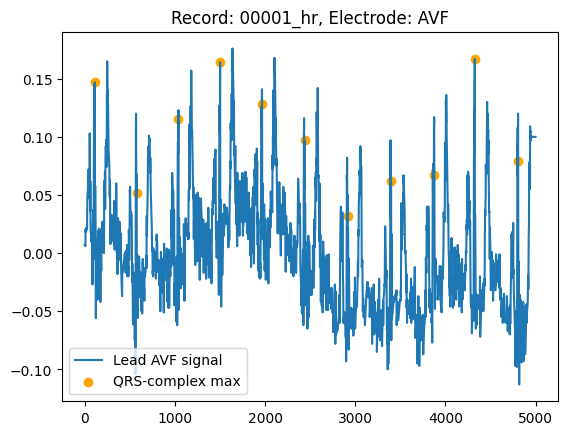

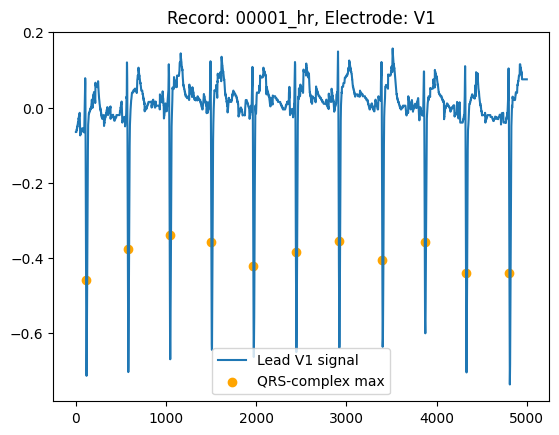

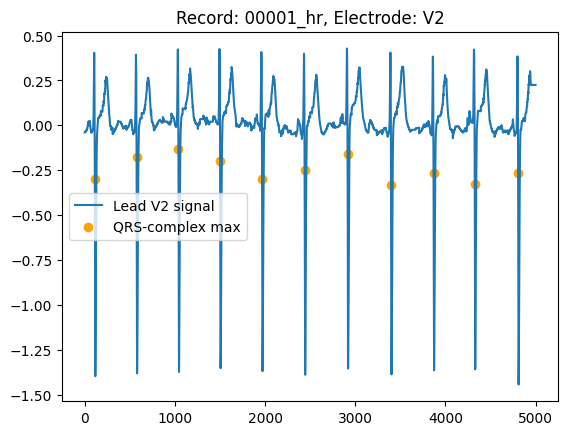

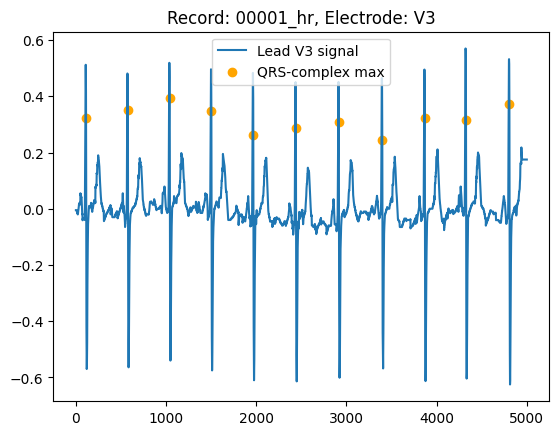

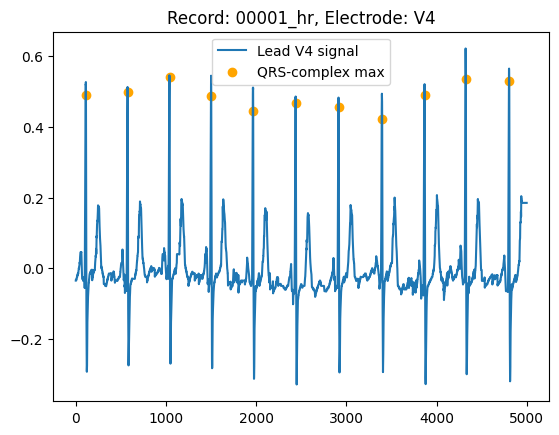

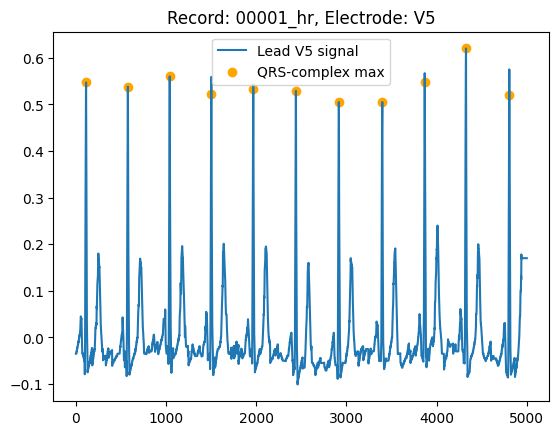

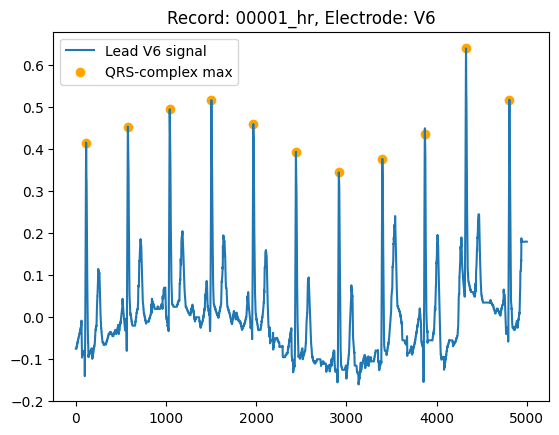

In [59]:
signal = X_selec[0]
record = Y.filename_hr.iloc[0].split('/')[-1]
peaks_indices = naive_qrs_complex_max_localizer(signal)
for i in range(12):
    plt.plot(signal[:, i], label=f'Lead {electrodes[i]} signal')
    plt.scatter(peaks_indices, signal[peaks_indices, i], color='orange', label='QRS-complex max')
    plt.title(f"Record: {record}, Electrode: {electrodes[i]}")
    plt.legend()
    plt.show()

The points we found should be close to the R-peaks provided in the metadata. We are going to check on a few samples that it is indeed the case.

We first convert the r_peaks strings to lists of values: 

In [60]:
def transform_string_to_list(x):
    return ast.literal_eval(','.join(x.split()).replace('[,', '['))

In [61]:
Y_selec.loc[:, 'r_peaks'] = Y_selec['r_peaks'].apply(transform_string_to_list)

<ipython-input-61-0648d1ece9ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_selec.loc[:, 'r_peaks'] = Y_selec['r_peaks'].apply(transform_string_to_list)


Note that the R-peaks provided in the metadata are given for a signal sampled at 100Hz. Since we are using a signal sampled at 500Hz, we will divide our indices by 5, in order to compare with the provided data.

We are just going to compare the first ten records:

In [62]:
for i in range(10):
    print('Peaks for record:', Y_selec.filename_lr.iloc[i].split('/')[-1])
    print('Naive algorithm QRS-complex:', naive_qrs_complex_max_localizer(X_selec[i]) // 5)
    print('Provided R-peaks:           ', np.array(Y_selec.r_peaks.iloc[i]))
    print()

Peaks for record: 00001_lr
Naive algorithm QRS-complex: [ 22 115 208 300 393 487 583 679 773 865 961]
Provided R-peaks:            [ 22 115 208 300 393 488 583 679 773 865 961]

Peaks for record: 00002_lr
Naive algorithm QRS-complex: [101 231 368 502 627 747 863]
Provided R-peaks:            [101 231 368 502 627 747 863]

Peaks for record: 00003_lr
Naive algorithm QRS-complex: [  7 104 202 298 394 485 577 670 764 857 951]
Provided R-peaks:            [  7 104 202 298 394 485 577 670 764 857 951]

Peaks for record: 00004_lr
Naive algorithm QRS-complex: [ 30 108 191 278 364 446 522 601 680 762 841 917]
Provided R-peaks:            [ 30 108 192 279 365 447 523 601 681 763 841 917 990]

Peaks for record: 00005_lr
Naive algorithm QRS-complex: [ 33 123 219 312 399 482 571 669 764 854 938]
Provided R-peaks:            [ 33 123 219 313 399 482 571 669 764 854 938]

Peaks for record: 00006_lr
Naive algorithm QRS-complex: [ 63 130 199 270 346 421 496 572 642 709 779 853 930]
Provided R-peaks:   

We see that the results are similar, except for record 00004 where the last peak is missing. Let's give a look at this record: 

In [63]:
signal = X_selec[3]

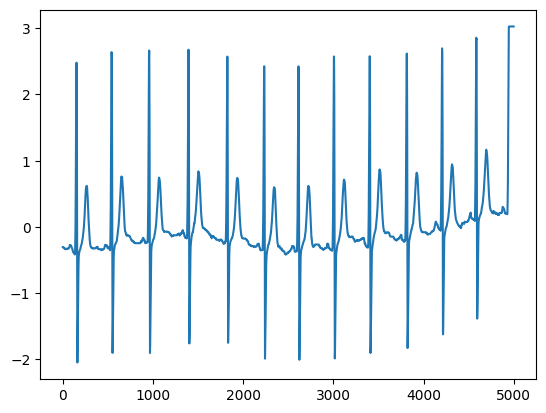

In [64]:
plt.plot(X_selec[3][:, 9])

We see that totally at the end, the signal seems to be blocked at a constant value. Since our drift removing function use a moving median, this should make the last peak mostly disappear. 

We confirm below that it is indeed the case:

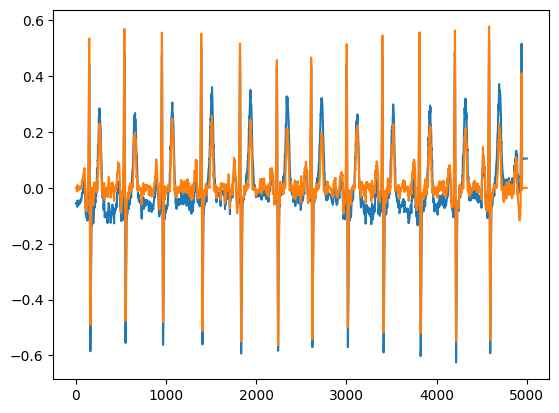

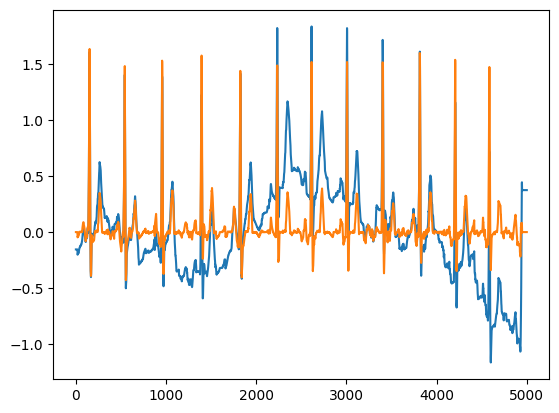

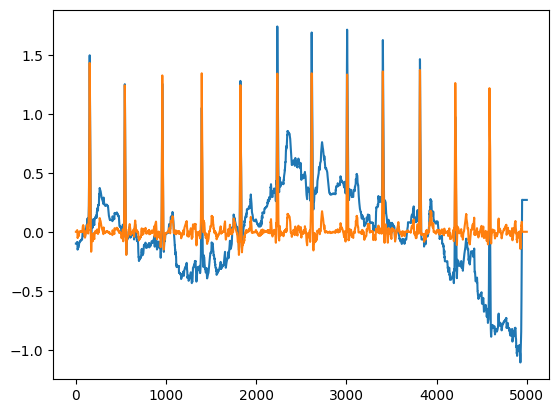

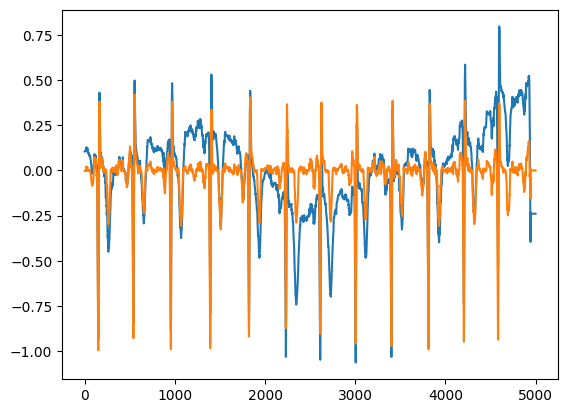

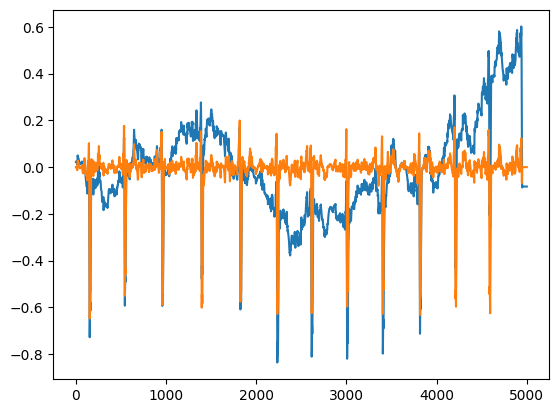

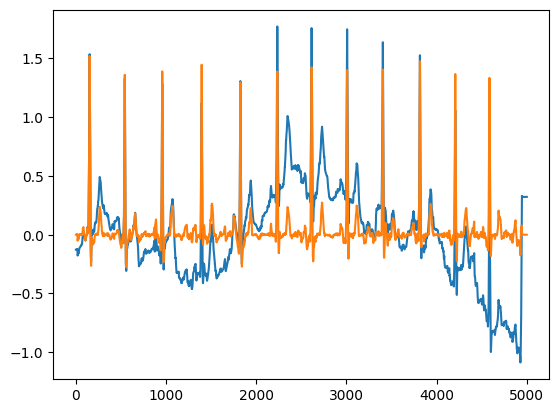

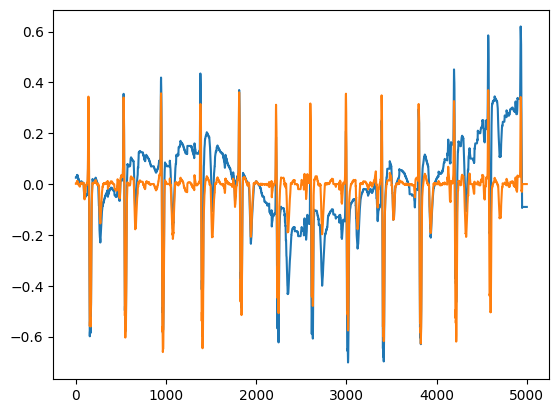

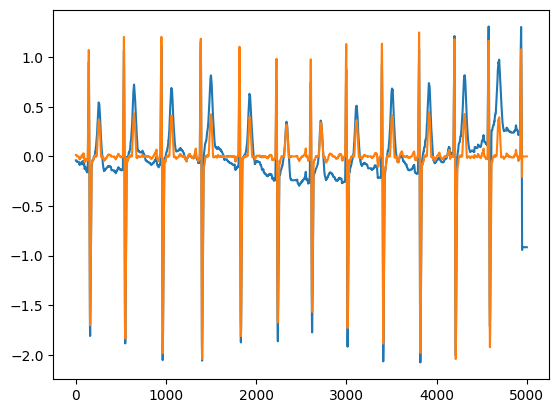

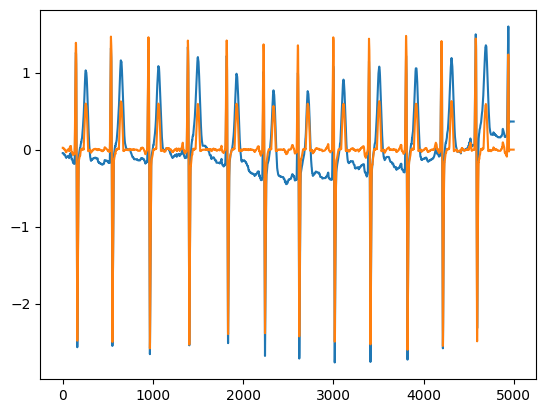

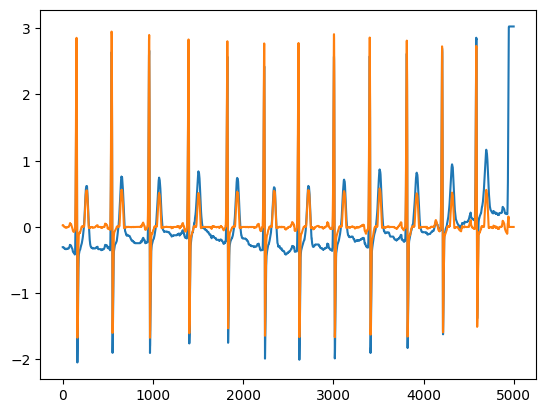

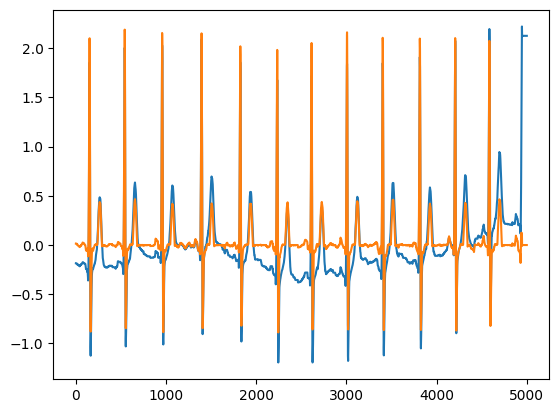

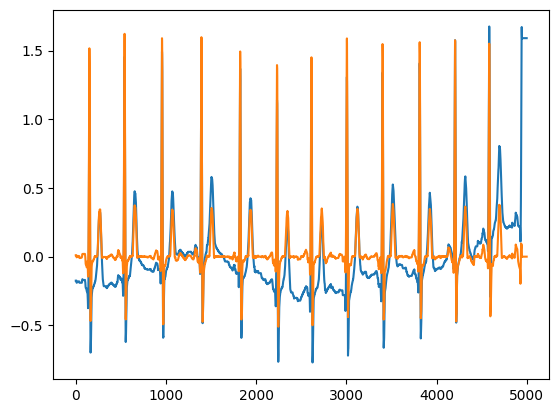

In [65]:
drift_removed = remove_drift(signal)
for i in range(12):
    plt.plot(signal[:, i])
    plt.plot(drift_removed[:, i])
    plt.show()

As guessed, the last peak is not visible in the combined signal:

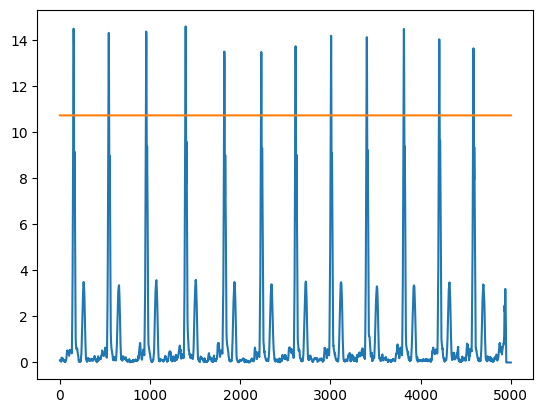

In [66]:
accumulated = np.sum(np.abs(drift_removed), axis = 1)
plt.plot(accumulated)
threshold = np.percentile(accumulated, 98)
plt.plot([threshold] * len(accumulated))

Let's check how many values at the end of the signal are identical.

In [67]:
np.all((signal[-50:] == signal[-1:]))

True

In [68]:
np.all((signal[-51:] == signal[-1:]))

False

The last 50 values are identical. We try again to localize the R-peaks, but we remove the last 49 values of the signal:

In [69]:
fixed_signal = signal[:-49]

In [70]:
print('Naive algorithm QRS-complex:', naive_qrs_complex_max_localizer(fixed_signal) // 5)
print('Provided R-peaks           :', np.array(Y_selec.r_peaks.iloc[3]))

Naive algorithm QRS-complex: [ 30 108 191 278 364 446 522 601 680 762 841 917 989]
Provided R-peaks           : [ 30 108 192 279 365 447 523 601 681 763 841 917 990]


We see that by fixing the problem at the end of the signal, our naive algorithm also works well for this record.

Let's now check 10 more records:

In [71]:
for i in range(10, 20):
    print('Peaks for record:', Y_selec.filename_lr.iloc[i].split('/')[-1])
    print('Naive algorithm QRS-complex:', naive_qrs_complex_max_localizer(X_selec[i]) // 5)
    print('Provided R-peaks:           ', np.array(Y_selec.r_peaks.iloc[i]))
    print()

Peaks for record: 00011_lr
Naive algorithm QRS-complex: [ 64 149 232 323 426 509 583 665 764 863 954]
Provided R-peaks:            [ 64 149 232 324 426 509 583 665 764 864 954]

Peaks for record: 00012_lr
Naive algorithm QRS-complex: [  1 118 242 374 496 616 751 879]
Provided R-peaks:            [  2 118 243 375 496 617 752]

Peaks for record: 00013_lr
Naive algorithm QRS-complex: [  3  77 151 226 301 376 452 529 606 683 760 838 916]
Provided R-peaks:            [  3  77 152 226 301 376 452 529 606 683 761 838]

Peaks for record: 00014_lr
Naive algorithm QRS-complex: [ 91 178 257 330 405 490 580 666 741 813 890 979]
Provided R-peaks:            [ 91 178 257 330 405 490 580 666 741 813 890 979]

Peaks for record: 00015_lr
Naive algorithm QRS-complex: [ 27 107 210 312 418 508 618 723 823 916]
Provided R-peaks:            [ 28 108 210 312 418 509 618 723 824 917]

Peaks for record: 00016_lr
Naive algorithm QRS-complex: [ 35 101 169 239 309 383 458 534 611 687 763 837 911 984]
Provided R-p

The results are similar, except for record 00012 and 00013 where our algorithm returns one more peak. Let's check these two records:

Peaks for record: 00012_lr
Naive algorithm QRS-complex: [  1 118 242 374 496 616 751 879]
Provided R-peaks:            [  2 118 243 375 496 617 752]


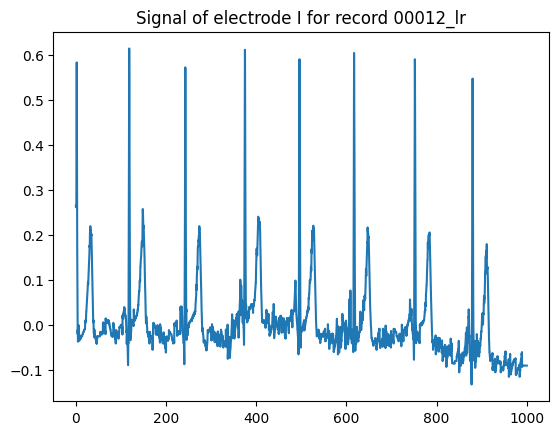

---

Peaks for record: 00013_lr
Naive algorithm QRS-complex: [  3  77 151 226 301 376 452 529 606 683 760 838 916]
Provided R-peaks:            [  3  77 152 226 301 376 452 529 606 683 761 838]


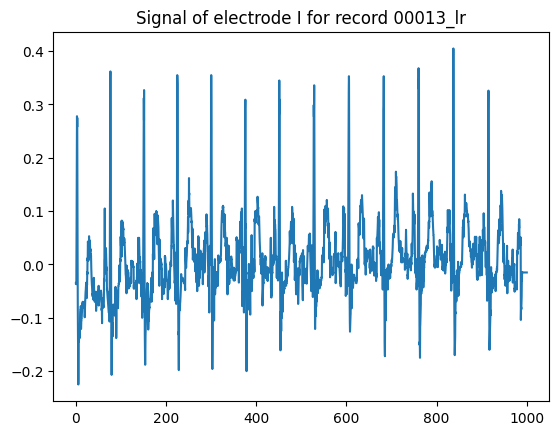

---

In [72]:
for i in range(11, 13):
    record = Y_selec.filename_lr.iloc[i].split('/')[-1]
    print('Peaks for record:', record)
    print('Naive algorithm QRS-complex:', naive_qrs_complex_max_localizer(X_selec[i]) // 5)
    print('Provided R-peaks:           ', np.array(Y_selec.r_peaks.iloc[i]))
    plt.plot(np.linspace(0, 1000, 5000), X_selec[i, :, 0])
    plt.title(f'Signal of electrode I for record {record}')
    plt.show()
    display(Markdown('---'))

We see that the error doesn't come from our algorithm but from the provided R-peaks. Indeed, for both records, the last R-peak is missing from the provided annotations. We should therefore be careful whenever we use the provided R-peaks, since the quality of these annotations might not be that good.

### Computing heart rate

We can use the peaks localization (corresponding to heart beats) to compute the heart rate. The instantaneous heart rate would be obtained by using the time difference between two consecutive peaks. 

In [73]:
def instantaneous_heart_rate(peak1, peak2, fs):
    """Compute the instantaneous heart rate in 
    Beats Per Minute
    
    Returns a float (we don't round the result)
    
    Args:
      peak1: index of a peak
      peak2: index of the following peak
      fs: sampling frequency in Hz
    """
    assert peak2 > peak1
    return fs / (peak2 - peak1) * 60

We show below the signal of the first electrode as well as the heart rate computed by the difference of two peaks for the first 5 records. Note that the heart rate computed from two peaks is plotted between these same two peaks.

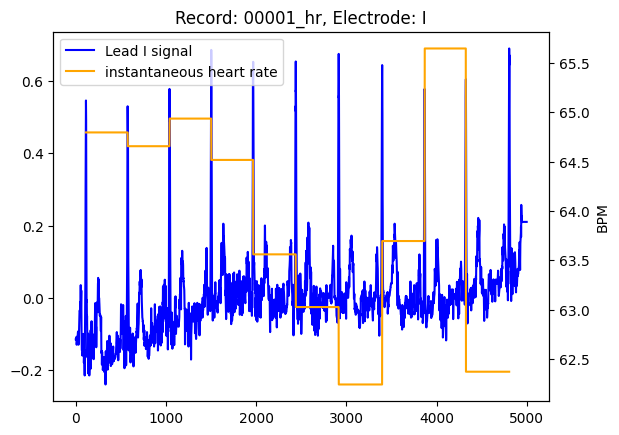

Median: 63.7 BPM
Mean: 63.9 BPM


---

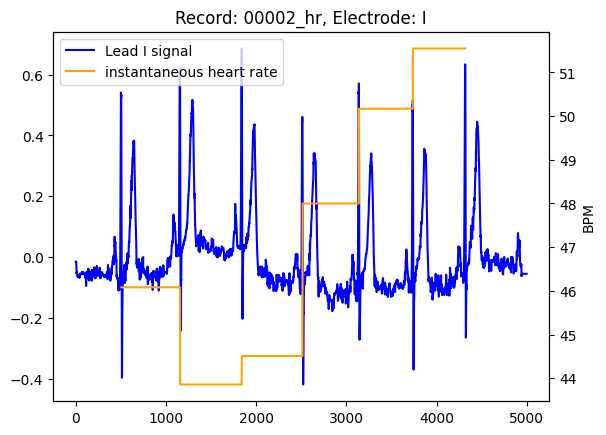

Median: 46.1 BPM
Mean: 47.2 BPM


---

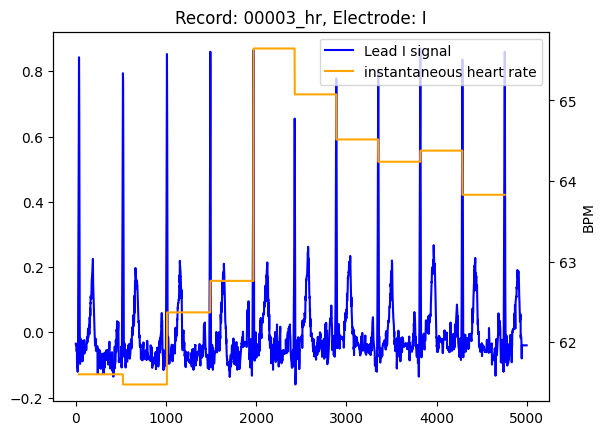

Median: 63.8 BPM
Mean: 63.6 BPM


---

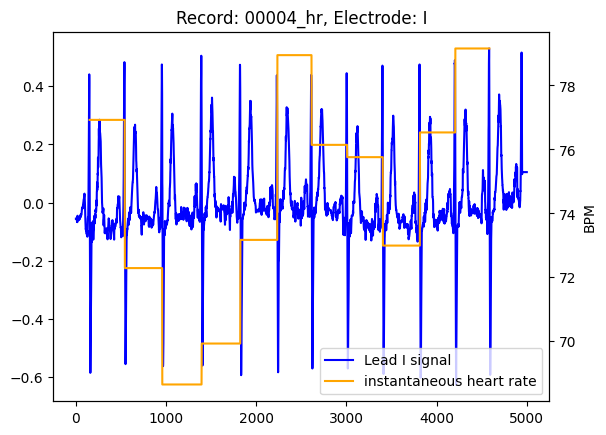

Median: 75.8 BPM
Mean: 74.4 BPM


---

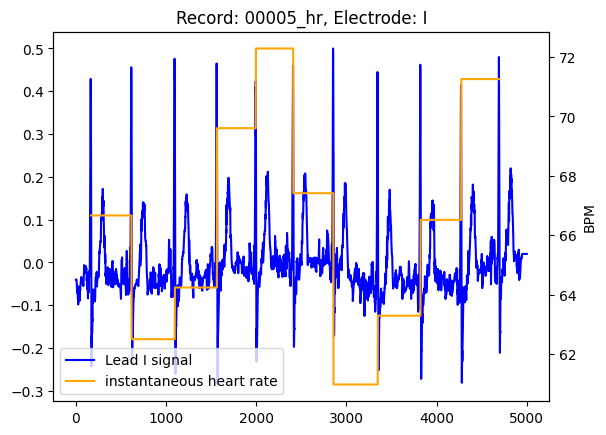

Median: 66.5 BPM
Mean: 66.3 BPM


---

In [74]:
for i in range(5):
    signal = X_selec[i]
    record = Y.filename_hr.iloc[i].split('/')[-1]
    peaks_indices = naive_qrs_complex_max_localizer(signal)
    heart_rate = np.full(len(signal), np.nan)
    for i in range(len(peaks_indices) - 1):
        ihr = instantaneous_heart_rate(peaks_indices[i],peaks_indices[i+1],sampling_rate)
        heart_rate[peaks_indices[i]:peaks_indices[i+1]] = ihr
    ax1 = plt.subplot()
    l1, = ax1.plot(signal[:, 0], color='blue')
    ax2 = ax1.twinx()
    l2, = ax2.plot(heart_rate, color='orange')
    ax2.set_ylabel('BPM')
    plt.legend([l1, l2], [f'Lead {electrodes[0]} signal', f'instantaneous heart rate'])
    plt.title(f"Record: {record}, Electrode: {electrodes[0]}")
    plt.show()
    print(f'Median: {np.nanmedian(heart_rate):.1f} BPM')
    print(f'Mean: {np.nanmean(heart_rate):.1f} BPM')
    display(Markdown('---'))

We see that the instantaneous heart rate can vary a lot. Furthermore, it has the following problems: it can be very sensitive to small location errors of the peaks, and the result can be extremely wrong if a peak is not detected or an extra peak is detected. Using the median of a few values would be more robust to errors.

### Note on repeated values in the signal

We have seen that for record 00004, the last 50 values of the signal are identical. We are now checking if this problem happens for many records:

In [75]:
number_repeat_last_50 = np.all(X[:, -50:] == X[:, -1:], axis=(1,2)).sum()
print('Number of records with identical last 50 values:', number_repeat_last_50)
print(f'Percentage of such records: {100*number_repeat_last_50 / len(X) :.2f}%')

Number of records with identical last 50 values: 21739
Percentage of such records: 99.72%


**There are 21739 records among 21801 records, that is 99.72% of the records, that have the problem of having the same last 50 values!**

In [76]:
np.all(X[:, -45:] == X[:, -1:], axis=(1,2)).sum()

21801

**Furthermore, all the records have at least the last 45 values that are identical. That means that we could at the very least discard the last 44 values of all the records, and therefore use only 4956 points among the 5000 points.**

We now check if many records have a big number of first values that are repeating too.

In [77]:
np.all(X[:, :2] == X[:, :1], axis=(1,2)).sum()

21504

In [78]:
np.all(X[:, :10] == X[:, :1], axis=(1,2)).sum()

86

Only 86 records among 21739 have their first 10 values repeating. This looks more reasonable.

*Note: while it would be safer to discard the repeated values, we will continue to use all the 5000 points in the remaining of this notebook.*

### Note on Q, R and S

We tested quickly to localize the Q, R and S points from the previous result. We started from the localized peaks, and looked for points in their neighborhood that could be annotated as Q, R and S. The main difference with what preceeds is that we combined the *signed* electrode signals rather than combining their absolute values. We then look for the maximum in this neighborhood and annotate it as R. We next consider that Q is on its left, and when the slope becomes negative (starting from R). And that S is on the right of R, when the slope becomes positive. That's a very naive way to proceed and we will not go further in that direction. Below is the result. 

We modified the previous function to also output the drift removed signal: 

In [79]:
def naive_qrs_complex_max_localizer(signal, percentile=98, tolerance=20, padding=50, return_no_drift=False):
    """Find the highest amplitude point of each QRS-complex
    
    Returns: an array of the indices of these points, the size of the array 
    being equal to the number of QRS-complexes detected.
    
    Args:
      signal: a 12 channels signal
      percentile: used for thresholding the signal
      tolerance: minimum space allowed between two peaks intervals
      padding: median sliding window has a length of 2 * padding
      return_no_drift: wether to return the drift remove signal or not
    """
    assert signal.shape[-1] == 12
    drift_removed = remove_drift(signal, padding)
    accumulated = np.sum(np.abs(drift_removed), axis = 1)
    threshold = np.percentile(accumulated, percentile)
    diff = np.diff((accumulated > threshold).astype(int), prepend=0, append=0)
    starts = np.nonzero(diff == 1)[0]
    ends = np.nonzero(diff == -1)[0]
    # We now remove any end followed by a start if they are close to each other 
    # That means the signal is below the threshold for just a few points
    indices = np.nonzero(starts[1:] - ends[:-1] < tolerance)
    for i in indices:
        starts = np.delete(starts, i + 1)
        ends = np.delete(ends, i)
    peaks_indices = []
    for start, end in zip(starts, ends):
        peaks_indices.append(start + accumulated[start:end].argmax())
    # If we don't want to look for the argmax, we can simply take the 
    # middle points of the intervals:
    # peaks_indices = (starts + ends - 1) // 2
    if return_no_drift:
        return np.array(peaks_indices), drift_removed
    return np.array(peaks_indices)

The following function is based on the above explanation. We just look for possible points in the neighborhood of the peaks computed as before.

In [80]:
def naive_qrs_localizer(signal, percentile=98, tolerance=20, padding=50, window=30, diff=0.0, debug=False):
    """Find the Q, R and S points of the QRS-complexes"""
    peaks, no_drift = naive_qrs_complex_max_localizer(signal, percentile=98, tolerance=20, padding=50, 
                                                return_no_drift=True)
    accumulated = np.sum(no_drift, axis = 1) # We use the signed signals here
    q_points = []
    r_points = []
    s_points = []
    for p in peaks:
        s = accumulated[max(0, p - window) : min(len(signal), p + window + 1)]
        r_point = max(0, p - window) + np.argmax(s)
        r_points.append(r_point)
        s = accumulated[max(0, r_point - window) : r_point - 4]
        delta = 5 + np.argmax(np.diff(s[::-1]) > -diff)
        q_points.append(max(0, r_point - delta))
        s = accumulated[r_point + 5 : min(len(signal), r_point + window + 1)]
        delta = 5 + np.argmax(np.diff(s) > -diff)
        s_point = min(len(signal), r_point + delta)
        local_argmin = np.argmin(accumulated[s_point-5:s_point+5])
        s_point = s_point - 5 + local_argmin 
        s_points.append(s_point)
    if debug:
        return np.array(q_points), np.array(r_points), np.array(s_points), peaks, accumulated
    return np.array(q_points), np.array(r_points), np.array(s_points)

We now compute the result on the first record.

In [81]:
signal = X_selec[0]
record = Y.filename_hr.iloc[0].split('/')[-1]
q, r, s, peaks, accumulated = naive_qrs_localizer(signal, debug=True)

Below are the Q, R and S points found for the first record:

In [82]:
q, r, s

(array([  98,  563, 1026, 1487, 1953, 2423, 2899, 3366, 3852, 4293, 4791]),
 array([ 108,  572, 1038, 1500, 1964, 2436, 2912, 3393, 3865, 4322, 4804]),
 array([ 123,  586, 1050, 1511, 1975, 2449, 2924, 3406, 3877, 4334, 4815]))

We now plot these points for all the QRS-complexes of the first record:

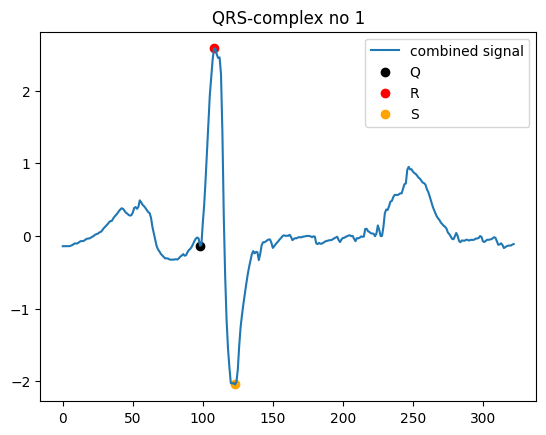

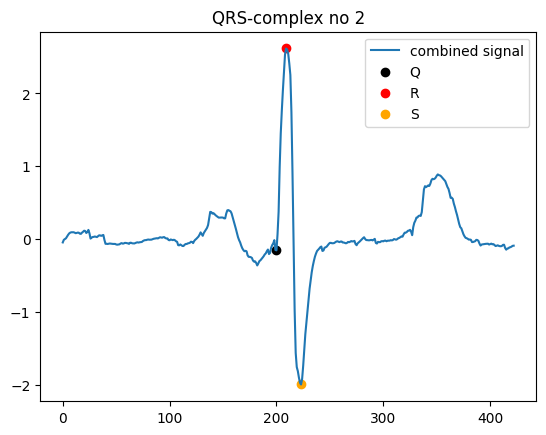

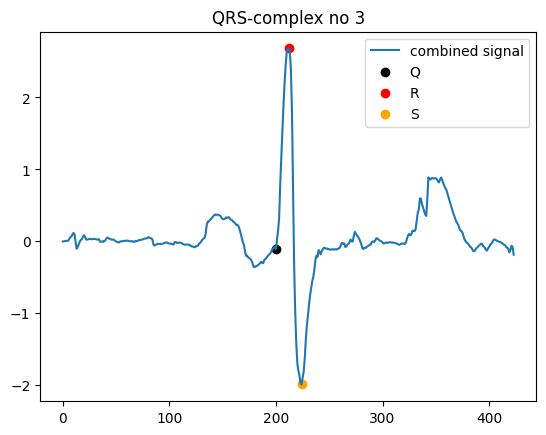

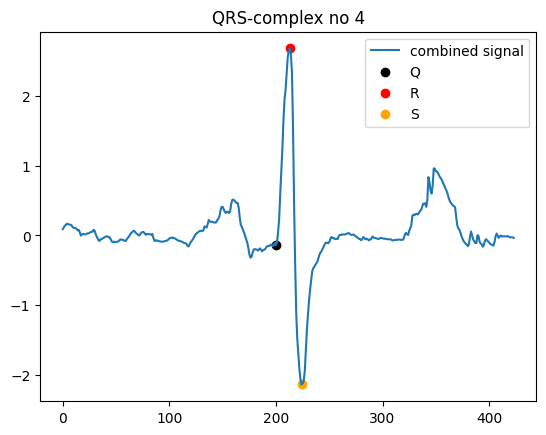

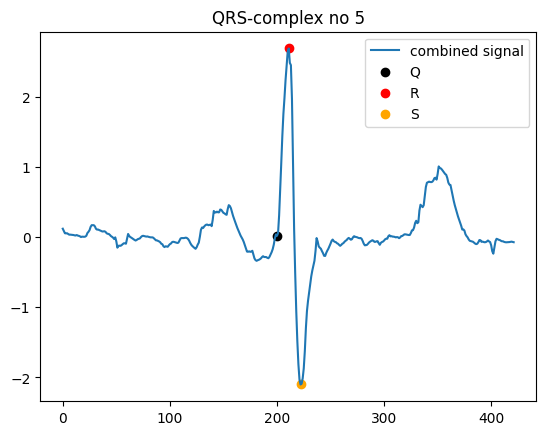

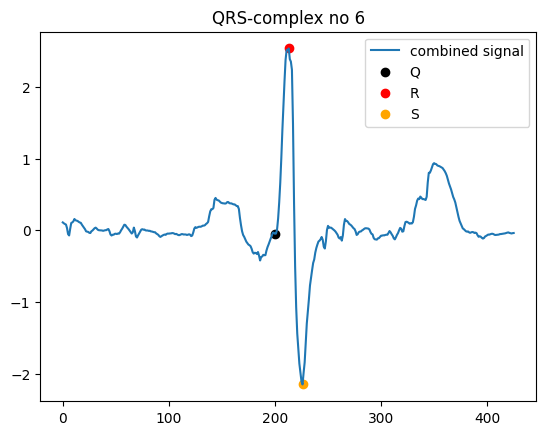

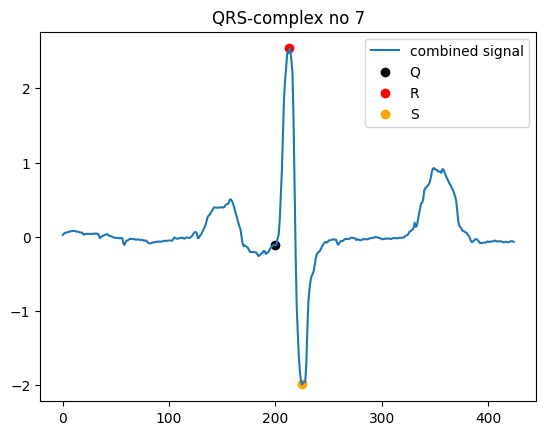

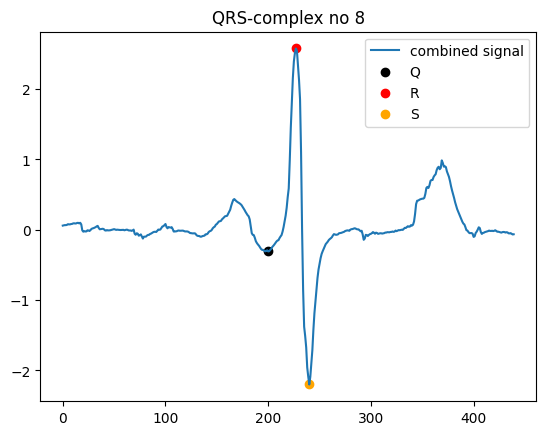

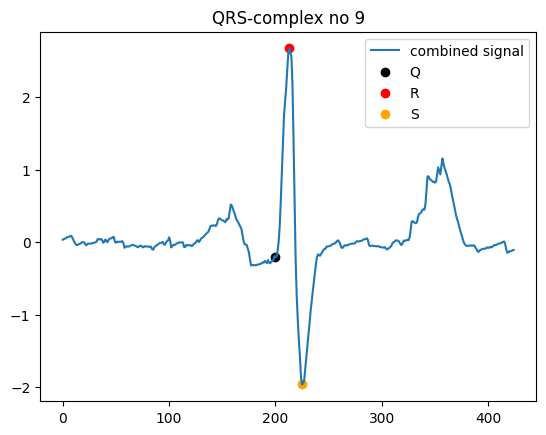

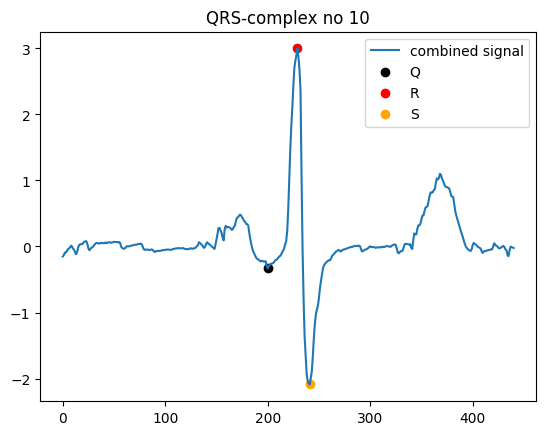

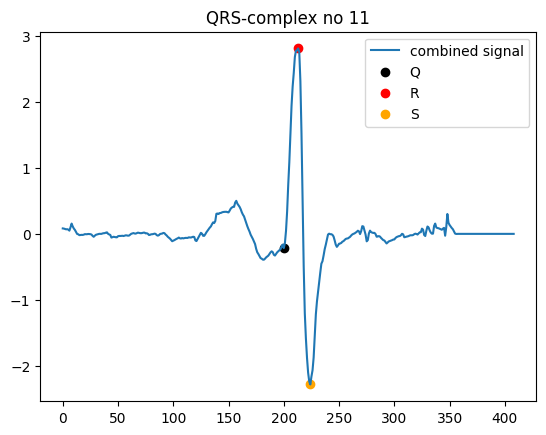

In [83]:
for i in range(len(r)):
    delta = min(q[i], 200)
    local_signal = accumulated[q[i] - delta : s[i]+200]
    plt.plot(local_signal, label='combined signal')
    plt.scatter(delta, local_signal[delta], color='black', label='Q')
    plt.scatter(delta + r[i] - q[i], local_signal[delta + r[i] - q[i]], color='red', label='R')
    plt.scatter(delta + s[i] - q[i], local_signal[delta + s[i] - q[i]], color='orange', label='S')
    plt.title(f'QRS-complex no {i+1}')
    plt.legend()
    plt.show()

### Available libraries

We have noticed two Python libraries that look particularly interesting for studying ECG signals:
- BioSPPy: https://biosppy.readthedocs.io
- NeuroKit2: https://neuropsychology.github.io/NeuroKit/

We will now give a quick look at NeuroKit2. In particular, NeuroKit2 has an example showing how to locate P, Q, S and T waves in ECG, see https://neuropsychology.github.io/NeuroKit/examples/ecg_delineate/ecg_delineate.html.  
Let's try to find the first three Q, R and S points of our first record for electrode I, using NeuroKit2.

We start by importing neurokit2:

In [84]:
import neurokit2 as nk

We create a cleaned signal that will be used for further analysis. Note that many cleaning methods are available, we just use the default one.

In [85]:
ecg_signal = signal[:, 0]
cleaned = nk.ecg_clean(ecg_signal)

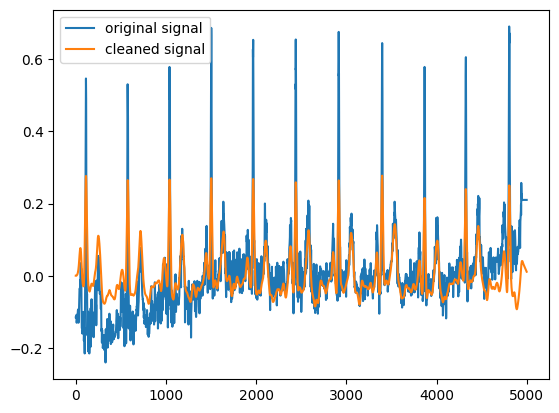

In [86]:
plt.plot(ecg_signal, label='original signal')
plt.plot(cleaned, label='cleaned signal')
plt.legend()

We now look for the R-peaks. Multiple methods are available, and we again just use the default one.

In [87]:
_, rpeaks = nk.ecg_peaks(cleaned, sampling_rate=sampling_rate)
print(rpeaks)

{'ECG_R_Peaks': array([ 576, 1040, 1502, 1967, 2439, 2915, 3397, 3867, 4324, 4806]), 'sampling_rate': 500}


The first three are plotted in red below:

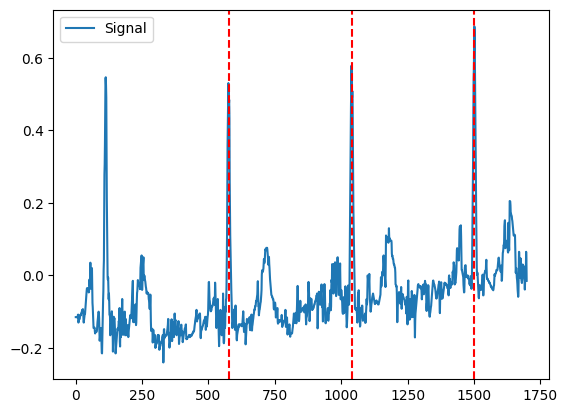

In [88]:
nk.events_plot(rpeaks['ECG_R_Peaks'][:3], ecg_signal[:1700])

We see that there is one R-peak missing, the first one.

We now compute the different waves information (i.e. P, Q, S and T): 

In [89]:
_, waves_peak = nk.ecg_delineate(nk.ecg_clean(ecg_signal), rpeaks, sampling_rate=sampling_rate, method="peaks")

In [90]:
waves_peak

{'ECG_P_Peaks': [516, 980, 1448, 1903, 2382, 2854, 3339, 3811, 4267, 4749],
 'ECG_Q_Peaks': [549, 1015, 1476, 1941, 2414, 2890, 3368, 3841, 4297, 4782],
 'ECG_S_Peaks': [642, 1083, 1529, 2011, 2505, 2970, 3428, 3893, 4352, 4890],
 'ECG_T_Peaks': [719, 1182, 1640, 2107, 2581, 3054, 3538, 4009, 4463, 4950],
 'ECG_P_Onsets': [482, 952, 1340, 1883, 2331, 2834, 3320, 3768, 4245, 4699],
 'ECG_T_Offsets': [747, 1216, 1667, 2151, 2655, 3097, 3574, 4040, 4492, nan]}

We select the first three Q, R and S peaks:

In [91]:
first_QRS = [waves_peak['ECG_Q_Peaks'][:3], 
             rpeaks['ECG_R_Peaks'][:3], 
             waves_peak['ECG_S_Peaks'][:3]]

and we display them:

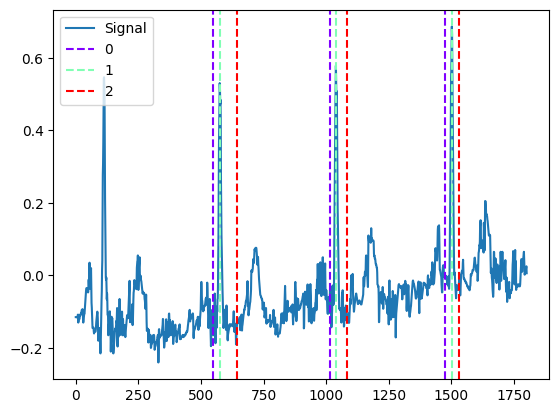

In [92]:
plot = nk.events_plot(first_QRS, ecg_signal[:rpeaks['ECG_R_Peaks'][2] + 300])

Another funnction of NeuroKit2 that looks interesting is `ecg_process`:

In [93]:
signals, info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)

In [94]:
signals

ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  ECG_P_Peaks  \
0      -0.115  -0.009210  63.829787     0.797525            0            0   
1      -0.115  -0.009150  63.829787     0.797525            0            0   
2      -0.115  -0.009280  63.829787     0.797525            0            0   
3      -0.115  -0.009530  63.829787     0.797525            0            0   
4      -0.115  -0.009810  63.829787     0.797525            0            0   
...       ...        ...        ...          ...          ...          ...   
4995    0.210   0.013683  62.240664     0.688505            0            0   
4996    0.210   0.013075  62.240664     0.688505            0            0   
4997    0.210   0.012465  62.240664     0.688505            0            0   
4998    0.210   0.011856  62.240664     0.688505            0            0   
4999    0.210   0.011246  62.240664     0.688505            0            0   

      ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  ECG_R_Offsets  \
0                0              0            0             0              0   
1                0              0            0             0              0   
2                0              0            0             0              0   
3                0              0            0             0              0   
4                0              0            0             0              0   
...            ...            ...          ...           ...            ...   
4995             0              0            0             0              0   
4996             0              0            0             0              0   
4997             0              0            0             0              0   
4998             0              0            0             0              0   
4999             0              0            0             0              0   

      ECG_S_Peaks  ECG_T_Peaks  ECG_T_Onsets  ECG_T_Offsets  ECG_Phase_Atrial  \
0               0            0             0              0               NaN   
1               0            0             0              0               NaN   
2               0            0             0              0               NaN   
3               0            0             0              0               NaN   
4               0            0             0              0               NaN   
...           ...          ...           ...            ...               ...   
4995            0            0             0              0               NaN   
4996            0            0             0              0               NaN   
4997            0            0             0              0               NaN   
4998            0            0             0              0               NaN   
4999            0            0             0              0               NaN   

      ECG_Phase_Completion_Atrial  ECG_Phase_Ventricular  \
0                             0.0                    NaN   
1                             0.0                    NaN   
2                             0.0                    NaN   
3                             0.0                    NaN   
4                             0.0                    NaN   
...                           ...                    ...   
4995                          0.0                    NaN   
4996                          0.0                    NaN   
4997                          0.0                    NaN   
4998                          0.0                    NaN   
4999                          0.0                    NaN   

      ECG_Phase_Completion_Ventricular  
0                                  0.0  
1                                  0.0  
2                                  0.0  
3                                  0.0  
4                                  0.0  
...                                ...  
4995                               0.0  
4996                               0.0  
4997                               0.0  
4998            

We see that this function provides a lot of information about our signal, including the peaks and the heart rate.

Finally, there is also a plotting function:

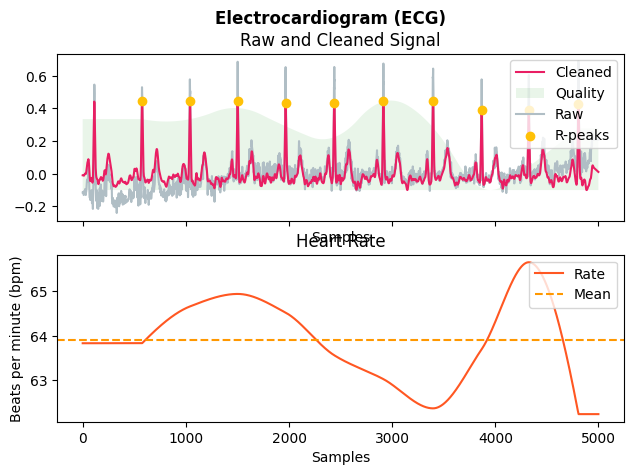

In [95]:
nk.ecg_plot(signals)

## Deep learning experiments

We are going to try to predict some information from the signal. We will use simple networks, easy to modify and quick to train, rather than SOTA networks. The goal is to have a first idea of the possibilities rather than trying to get the best result possible.

### Training, validation and test sets

We use the provided stratified folds to create our train, validation and test sets. If we plan to further use this dataset, we should check that the folds are indeed well created, well balanced and without any leakage.

In [96]:
X_train = X_selec[Y_selec.strat_fold < 9]
Y_train = Y_selec.loc[Y_selec.strat_fold < 9]
X_valid = X_selec[Y_selec.strat_fold == 9]
Y_valid = Y_selec.loc[Y_selec.strat_fold == 9]
X_test = X_selec[Y_selec.strat_fold == 10]
Y_test = Y_selec.loc[Y_selec.strat_fold == 10]

We will now standardize our data per electrode channel:

In [97]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

### Predicting the patient's age from his ECG

The goal here is to confirm that the quality of the dataset is sufficient enough to extract some information from the signal, and that using 1D convolutional networks could bring interesting results. We chose the patient's age as a target because it is available for all records, and we can easily train a regression model with MSE loss.

Let's not forget that any patient older than 90 years old has an age set to 300. We will convert these values to 90:

In [98]:
Y_train_age = Y_train.age.copy()
Y_train_age[Y_train_age == 300] = 90

In [99]:
Y_valid_age = Y_valid.age.copy()
Y_valid_age[Y_valid_age == 300] = 90

In [100]:
Y_test_age = Y_test.age.copy()
Y_test_age[Y_test_age == 300] = 90

We will take as a reference the mean of the ages in the train set:

In [101]:
print('Constant mean model MSE on validation:', np.mean((Y_valid_age - Y_train_age.mean())**2))

Constant mean model MSE on validation: 298.0281257359001


A model with a validation MSE smaller than 298 performs better than the mean of the ages.

We are adapting a small Xception network taken from a simple Keras example (see https://keras.io/examples/vision/image_classification_from_scratch/) to 1D signals:

In [102]:
from tensorflow.keras import layers
from tensorflow import keras


def get_model(signal_size):
    inputs = keras.Input(shape=signal_size)

    # Entry block
    x = layers.Conv1D(32, 9, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters, strides in zip([32, 64, 128], [2, 2, 5]):
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv1D(filters, 9, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv1D(filters, 9, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling1D(9, strides=strides, padding="same")(x)

        # Project residual
        residual = layers.Conv1D(filters, 1, strides=strides, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv1D(2 * filters, 9, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation=None)(x)
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

regression_model = get_model((5000, 12))

In [103]:
regression_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2500, 32)     3488        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2500, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2500, 32)     0           ['batch_normalization[0][0]']

In [104]:
regression_model.compile(optimizer='adam', loss='mse')

We now start the training. To keep things very simple, we do not use any callback to store the best weights, and we just train for 10 epochs.

In [105]:
checkpoint_filepath = 'checkpoint_age'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [106]:
regression_model.fit(X_train, Y_train_age.to_numpy(), validation_data=(X_valid, Y_valid_age.to_numpy()), epochs=20, batch_size=64, callbacks=[model_checkpoint_callback])

Epoch 1/20
252/252 [==============================] - ETA: 0s - loss: 1932.3534

INFO:tensorflow:Assets written to: checkpoint_age/assets


INFO:tensorflow:Assets written to: checkpoint_age/assets


252/252 [==============================] - 27s 93ms/step - loss: 1932.3534 - val_loss: 1355.2535
Epoch 2/20
251/252 [============================>.] - ETA: 0s - loss: 221.2169

INFO:tensorflow:Assets written to: checkpoint_age/assets


INFO:tensorflow:Assets written to: checkpoint_age/assets


252/252 [==============================] - 23s 90ms/step - loss: 221.2151 - val_loss: 384.2123
Epoch 3/20
251/252 [============================>.] - ETA: 0s - loss: 134.3443

INFO:tensorflow:Assets written to: checkpoint_age/assets


INFO:tensorflow:Assets written to: checkpoint_age/assets


252/252 [==============================] - 23s 91ms/step - loss: 134.3599 - val_loss: 114.3906
Epoch 4/20
252/252 [==============================] - 20s 80ms/step - loss: 130.5396 - val_loss: 120.5932
Epoch 5/20
252/252 [==============================] - 20s 80ms/step - loss: 123.7342 - val_loss: 116.0316
Epoch 6/20
251/252 [============================>.] - ETA: 0s - loss: 120.9294

INFO:tensorflow:Assets written to: checkpoint_age/assets


INFO:tensorflow:Assets written to: checkpoint_age/assets


252/252 [==============================] - 23s 91ms/step - loss: 120.9319 - val_loss: 103.8608
Epoch 7/20
252/252 [==============================] - 20s 80ms/step - loss: 116.1779 - val_loss: 114.4855
Epoch 8/20
252/252 [==============================] - 20s 80ms/step - loss: 111.3452 - val_loss: 107.3295
Epoch 9/20
251/252 [============================>.] - ETA: 0s - loss: 109.5210

INFO:tensorflow:Assets written to: checkpoint_age/assets


INFO:tensorflow:Assets written to: checkpoint_age/assets


252/252 [==============================] - 23s 91ms/step - loss: 109.5150 - val_loss: 102.7282
Epoch 10/20
252/252 [==============================] - 20s 80ms/step - loss: 108.0013 - val_loss: 150.1165
Epoch 11/20
252/252 [==============================] - 20s 80ms/step - loss: 106.6252 - val_loss: 155.6962
Epoch 12/20
252/252 [==============================] - 19s 75ms/step - loss: 105.3069 - val_loss: 104.1215
Epoch 13/20
252/252 [==============================] - 18s 73ms/step - loss: 102.9194 - val_loss: 110.1317
Epoch 14/20
251/252 [============================>.] - ETA: 0s - loss: 100.2065

INFO:tensorflow:Assets written to: checkpoint_age/assets


INFO:tensorflow:Assets written to: checkpoint_age/assets


252/252 [==============================] - 21s 84ms/step - loss: 100.2375 - val_loss: 98.9891
Epoch 15/20
251/252 [============================>.] - ETA: 0s - loss: 98.4572

INFO:tensorflow:Assets written to: checkpoint_age/assets


INFO:tensorflow:Assets written to: checkpoint_age/assets


252/252 [==============================] - 21s 84ms/step - loss: 98.4652 - val_loss: 97.6282
Epoch 16/20
252/252 [==============================] - 18s 73ms/step - loss: 95.2745 - val_loss: 108.0969
Epoch 17/20
252/252 [==============================] - 18s 73ms/step - loss: 95.3091 - val_loss: 134.9384
Epoch 18/20
251/252 [============================>.] - ETA: 0s - loss: 93.2664

INFO:tensorflow:Assets written to: checkpoint_age/assets


INFO:tensorflow:Assets written to: checkpoint_age/assets


252/252 [==============================] - 21s 84ms/step - loss: 93.2614 - val_loss: 96.0885
Epoch 19/20
252/252 [==============================] - 18s 73ms/step - loss: 92.7074 - val_loss: 182.6072
Epoch 20/20
252/252 [==============================] - 18s 73ms/step - loss: 91.4647 - val_loss: 135.1741


In [107]:
# Freeing memory
keras.backend.clear_session()
del regression_model
gc.collect()

97560

We now load the model with best weights:

In [108]:
regression_model = keras.models.load_model(checkpoint_filepath)

Let's predict ages on our test set:

In [109]:
preds = regression_model.predict(X_test)

65/65 [==============================] - 1s 11ms/step


In [110]:
print('MSE on test set:', np.mean((preds[:, 0] - Y_test_age)**2))

MSE on test set: 96.57784


We see that our MSE is significantly below 298, the MSE obtained by taking the average of the ages (see above), that means that our model is able to find interesting information in the signal in order to predict a patient's age.

Let's give a look at the MAE:

In [111]:
print('MAE of the average of ages on test set:', (Y_test_age - Y_test_age.mean()).abs().mean())

MAE of the average of ages on test set: 14.221401075224689


In [112]:
print('Predictions MAE on test set:', (Y_test_age - preds[:, 0]).abs().mean())

Predictions MAE on test set: 7.7205925


The average error on the prediction of patients' ages is around 8 years.

In [113]:
# Free up memory
keras.backend.clear_session()

### Predicting the number of R-peaks

Before predicting the location of R-peaks in the next section, we are first going to check that we can approximately predict the number of peaks. It is a simpler problem than finding the R-peaks locations since we can do a simple regression and therefore just use the same model as before.

We first compute the number of R-peaks:

In [114]:
Y_train.loc[:, 'r_peaks_count'] = Y_train['r_peaks'].apply(len)
Y_valid.loc[:, 'r_peaks_count'] = Y_valid['r_peaks'].apply(len)
Y_test.loc[:, 'r_peaks_count'] = Y_test['r_peaks'].apply(len)

<ipython-input-114-b1e4e23f1b05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train.loc[:, 'r_peaks_count'] = Y_train['r_peaks'].apply(len)
<ipython-input-114-b1e4e23f1b05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_valid.loc[:, 'r_peaks_count'] = Y_valid['r_peaks'].apply(len)
<ipython-input-114-b1e4e23f1b05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

We use the same model as before:

In [115]:
checkpoint_filepath = 'checkpoint_peaks_count'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [116]:
regression_model.fit(X_train, Y_train.r_peaks_count.to_numpy(), validation_data=(X_valid, Y_valid.r_peaks_count.to_numpy()), epochs=20, batch_size=64, callbacks=[model_checkpoint_callback])

Epoch 1/20
251/252 [============================>.] - ETA: 0s - loss: 355.5028

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 23s 85ms/step - loss: 355.4850 - val_loss: 60.5221
Epoch 2/20
251/252 [============================>.] - ETA: 0s - loss: 12.4795

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 21s 85ms/step - loss: 12.4799 - val_loss: 3.4938
Epoch 3/20
251/252 [============================>.] - ETA: 0s - loss: 3.9603

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 21s 84ms/step - loss: 3.9602 - val_loss: 2.8878
Epoch 4/20
251/252 [============================>.] - ETA: 0s - loss: 2.6896

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 21s 84ms/step - loss: 2.6954 - val_loss: 1.8098
Epoch 5/20
251/252 [============================>.] - ETA: 0s - loss: 2.5745

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 24s 96ms/step - loss: 2.5751 - val_loss: 0.6301
Epoch 6/20
251/252 [============================>.] - ETA: 0s - loss: 1.8674

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 25s 99ms/step - loss: 1.8673 - val_loss: 0.5082
Epoch 7/20
251/252 [============================>.] - ETA: 0s - loss: 1.6933

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 23s 92ms/step - loss: 1.6933 - val_loss: 0.4469
Epoch 8/20
251/252 [============================>.] - ETA: 0s - loss: 1.5538

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 23s 90ms/step - loss: 1.5541 - val_loss: 0.3802
Epoch 9/20
252/252 [==============================] - 20s 80ms/step - loss: 1.4615 - val_loss: 0.6307
Epoch 10/20
251/252 [============================>.] - ETA: 0s - loss: 1.3332

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 23s 92ms/step - loss: 1.3331 - val_loss: 0.3173
Epoch 11/20
251/252 [============================>.] - ETA: 0s - loss: 1.2610

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 23s 91ms/step - loss: 1.2610 - val_loss: 0.2641
Epoch 12/20
252/252 [==============================] - 20s 80ms/step - loss: 1.2031 - val_loss: 1.6025
Epoch 13/20
252/252 [==============================] - 20s 80ms/step - loss: 1.1733 - val_loss: 0.8536
Epoch 14/20
252/252 [==============================] - 20s 80ms/step - loss: 1.0913 - val_loss: 0.4371
Epoch 15/20
252/252 [==============================] - 20s 80ms/step - loss: 1.0484 - val_loss: 0.3293
Epoch 16/20
252/252 [==============================] - 20s 80ms/step - loss: 0.9982 - val_loss: 0.3243
Epoch 17/20
252/252 [==============================] - 20s 80ms/step - loss: 0.9803 - val_loss: 0.2845
Epoch 18/20
251/252 [============================>.] - ETA: 0s - loss: 0.9614

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 23s 90ms/step - loss: 0.9615 - val_loss: 0.2547
Epoch 19/20
252/252 [==============================] - 20s 80ms/step - loss: 0.9185 - val_loss: 0.3609
Epoch 20/20
251/252 [============================>.] - ETA: 0s - loss: 0.8765

INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


INFO:tensorflow:Assets written to: checkpoint_peaks_count/assets


252/252 [==============================] - 23s 91ms/step - loss: 0.8766 - val_loss: 0.2256


In [117]:
# Freeing memory
keras.backend.clear_session()
del regression_model
gc.collect()

49540

We now load the best model:

In [118]:
regression_model = keras.models.load_model(checkpoint_filepath)

and make predictions on the test set:

In [119]:
preds = regression_model.predict(X_test)

65/65 [==============================] - 1s 11ms/step


Let's check the difference between rounded predictions and ground truth for the first 20 samples:

In [120]:
for i, (p, t) in enumerate(zip(preds[:20, 0], Y_test.r_peaks_count.iloc[:20])):
    r = round(p)
    print(f'Sample {i} - Rounded prediction: {r}, Ground truth: {t}, Difference: {abs(r - t)}')

Sample 0 - Rounded prediction: 10, Ground truth: 10, Difference: 0
Sample 1 - Rounded prediction: 10, Ground truth: 10, Difference: 0
Sample 2 - Rounded prediction: 10, Ground truth: 11, Difference: 1
Sample 3 - Rounded prediction: 11, Ground truth: 11, Difference: 0
Sample 4 - Rounded prediction: 10, Ground truth: 10, Difference: 0
Sample 5 - Rounded prediction: 12, Ground truth: 12, Difference: 0
Sample 6 - Rounded prediction: 9, Ground truth: 9, Difference: 0
Sample 7 - Rounded prediction: 10, Ground truth: 10, Difference: 0
Sample 8 - Rounded prediction: 9, Ground truth: 10, Difference: 1
Sample 9 - Rounded prediction: 12, Ground truth: 12, Difference: 0
Sample 10 - Rounded prediction: 12, Ground truth: 12, Difference: 0
Sample 11 - Rounded prediction: 13, Ground truth: 12, Difference: 1
Sample 12 - Rounded prediction: 12, Ground truth: 12, Difference: 0
Sample 13 - Rounded prediction: 14, Ground truth: 14, Difference: 0
Sample 14 - Rounded prediction: 13, Ground truth: 14, Differe

The MAE of the predictions on our test set is:

In [121]:
print('MAE:', np.mean(np.abs(preds[:, 0] - Y_test.r_peaks_count)))

MAE: 0.37253316112638385


If we round the predictions to the closest integer, the accuracy is:

In [122]:
print(f'accuracy: {100 * np.mean(np.round(preds[:, 0]) == Y_test.r_peaks_count):.2f}%')

accuracy: 77.14%


This result doesn't seem too bad. However, we should be a bit careful about it since we have previously noticed a few problems in the r_peaks annotations.

In [123]:
# Freeing memory
keras.backend.clear_session()
del regression_model
gc.collect()

62126

### Predicting the location of the peaks

We adapt the simple segmentation model from the Keras example https://keras.io/examples/vision/oxford_pets_image_segmentation/ to 1D and choose the strides so that the output also has 5000 points:

In [124]:
from tensorflow.keras import layers
from tensorflow import keras


def get_model(signal_size, num_classes):
    inputs = keras.Input(shape=signal_size)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv1D(32, 9, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters, strides in zip([32, 64, 128], [2, 2, 5]):
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv1D(filters, 9, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv1D(filters, 9, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling1D(9, strides=strides, padding="same")(x)

        # Project residual
        residual = layers.Conv1D(filters, 1, strides=strides, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters, upsampling in zip([128, 64, 32, 16], [5, 2, 2, 2]):
        x = layers.Activation("relu")(x)
        x = layers.Conv1DTranspose(filters, 9, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv1DTranspose(filters, 9, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling1D(upsampling)(x)

        # Project residual
        residual = layers.UpSampling1D(upsampling)(previous_block_activation)
        residual = layers.Conv1D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv1D(num_classes, 9, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
segmentation_model = get_model((5000,12), 1)
segmentation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2500, 32)     3488        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2500, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2500, 32)     0           ['batch_normalization[0][0]']

We create the targets as arrays of lengths 5000 with a value of zero outside the R-peaks and a value of 1 at the R-peaks locations. Since the provided R-peaks values were given for a sampling of 100Hz, but we are using signals sampled at 500Hz, we just multiply the indices of the R-peaks locations by 5. This approximation of the R-peaks location is a little bit rough, but it should be good enough for our purpose. 

In [125]:
target_train = np.zeros((len(Y_train), 5000, 1))
for i, peaks in enumerate(Y_train.r_peaks):
    for p in peaks:
        target_train[i, p * 5] = 1

Let's plot the target of the first training record:

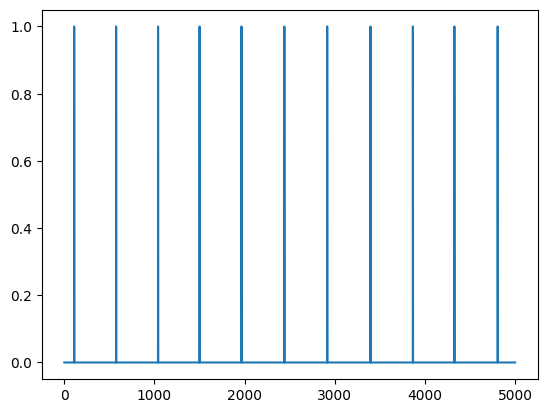

In [126]:
plt.plot(target_train[0])

We create the same way the validation and test targets:

In [127]:
target_valid = np.zeros((len(Y_valid), 5000, 1))
for i, peaks in enumerate(Y_valid.r_peaks):
    for p in peaks:
        target_valid[i, p * 5] = 1
        
target_test = np.zeros((len(Y_test), 5000, 1))
for i, peaks in enumerate(Y_test.r_peaks):
    for p in peaks:
        target_test[i, p * 5] = 1

In [128]:
segmentation_model.compile(optimizer='adam', loss='binary_crossentropy')

In [129]:
checkpoint_filepath = 'checkpoint_peaks'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [130]:
segmentation_model.fit(X_train, target_train, validation_data=(X_valid, target_valid), epochs=10, batch_size=64, callbacks=[model_checkpoint_callback])

Epoch 1/10
252/252 [==============================] - ETA: 0s - loss: 0.0245

INFO:tensorflow:Assets written to: checkpoint_peaks/assets


INFO:tensorflow:Assets written to: checkpoint_peaks/assets


252/252 [==============================] - 135s 206ms/step - loss: 0.0245 - val_loss: 0.0138
Epoch 2/10
252/252 [==============================] - ETA: 0s - loss: 0.0026

INFO:tensorflow:Assets written to: checkpoint_peaks/assets


INFO:tensorflow:Assets written to: checkpoint_peaks/assets


252/252 [==============================] - 50s 199ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 3/10
252/252 [==============================] - ETA: 0s - loss: 0.0022

INFO:tensorflow:Assets written to: checkpoint_peaks/assets


INFO:tensorflow:Assets written to: checkpoint_peaks/assets


252/252 [==============================] - 50s 199ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 4/10
252/252 [==============================] - ETA: 0s - loss: 0.0020

INFO:tensorflow:Assets written to: checkpoint_peaks/assets


INFO:tensorflow:Assets written to: checkpoint_peaks/assets


252/252 [==============================] - 50s 199ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 5/10
252/252 [==============================] - 43s 170ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 6/10
252/252 [==============================] - 43s 171ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 7/10
252/252 [==============================] - 43s 171ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 8/10
252/252 [==============================] - ETA: 0s - loss: 0.0018

INFO:tensorflow:Assets written to: checkpoint_peaks/assets


INFO:tensorflow:Assets written to: checkpoint_peaks/assets


252/252 [==============================] - 50s 198ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/10
252/252 [==============================] - 41s 163ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 10/10
252/252 [==============================] - 41s 163ms/step - loss: 0.0017 - val_loss: 0.0024


In [131]:
# Freeing memory
keras.backend.clear_session()
del segmentation_model
gc.collect()

206082

We now load the model with best weights:

In [132]:
segmentation_model = keras.models.load_model(checkpoint_filepath)

and make predictions on our test set:

In [133]:
preds_peaks = segmentation_model.predict(X_test)

65/65 [==============================] - 3s 23ms/step


We now plot the result for 5 different records taken at random:

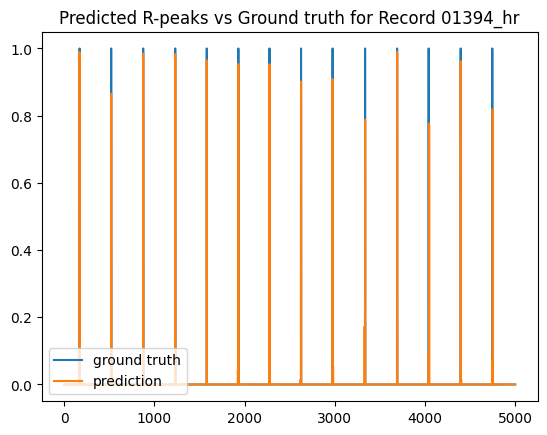

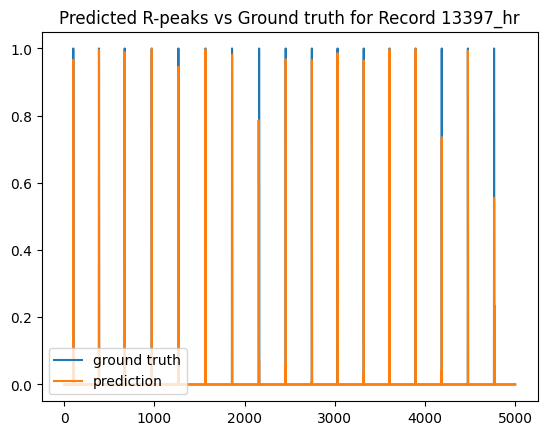

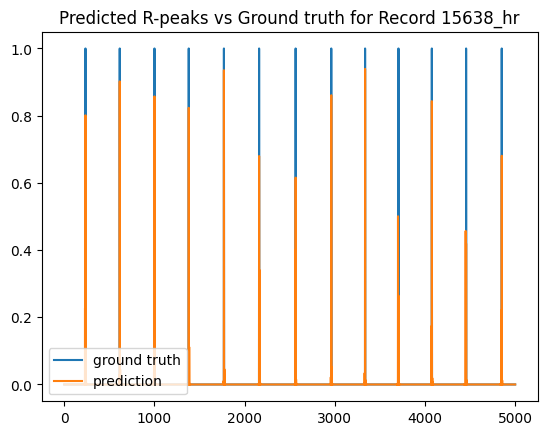

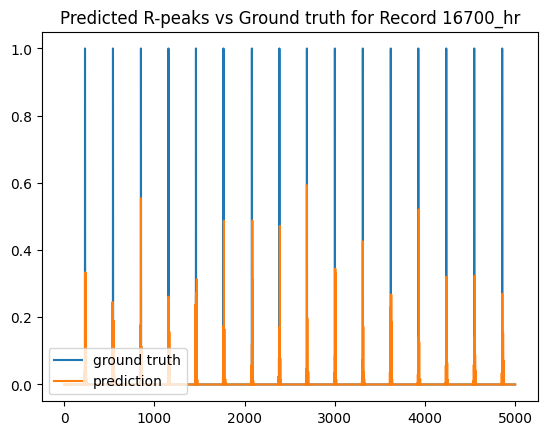

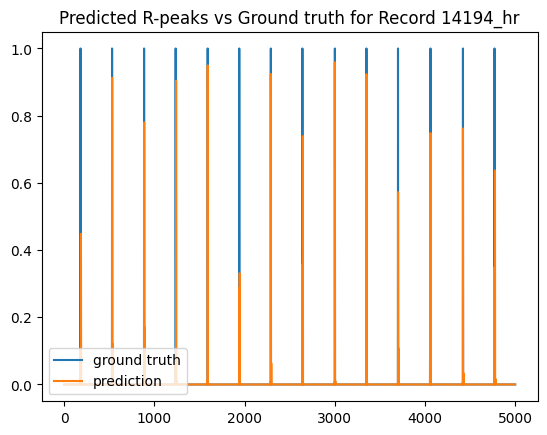

In [134]:
for i in np.random.randint(len(target_test), size=5):
    plt.plot(target_test[i], label='ground truth')
    plt.plot(preds_peaks[i], label='prediction')
    plt.title(f"Predicted R-peaks vs Ground truth for Record {Y_test.iloc[i].filename_hr.split('/')[-1]}")
    plt.legend(loc='lower left')
    plt.show()

We see that the R-peaks are correctly localized. For a few R-peaks, the prediction seems a bit weak. This could be due to multiple reasons. The first one is that our target is not very precise (we just multiplied by 5 the provided R-peaks), so that our model can only predict roughly the location of our R-peaks. Furthermore, let's not forget that we have noticed some problems in the annotations of the R-peaks and that we have not asserted their quality. The second reason is that our model has only been trained for a few epochs. But it could also be due to other reasons, such as our model being too simple to predict precisely the result.

In [135]:
# Freeing memory
keras.backend.clear_session()
del segmentation_model
gc.collect()

213844

### Predicting diagnostic superclass

In [136]:
from tensorflow.keras import layers
from tensorflow import keras

def get_model(signal_size, simultaneous_classes):
    inputs = keras.Input(shape=signal_size)

    # Entry block
    x = layers.Conv1D(32, 9, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters, strides in zip([32, 64, 128], [2, 2, 5]):
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv1D(filters, 9, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv1D(filters, 9, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling1D(9, strides=strides, padding="same")(x)

        # Project residual
        residual = layers.Conv1D(filters, 1, strides=strides, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv1D(2 * filters, 9, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(simultaneous_classes, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

classification_model = get_model((5000, 12), 5)

We saw when we studied the metadata that there are 405 records without diagnostic. We will remove those from our data.

In [137]:
def remove_no_diagnostic(x, y):
    selected = y.diagnostic_superclass.apply(len) > 0
    x_diagnostic = x[selected]
    y_diagnostic = y.loc[selected]
    return x_diagnostic, y_diagnostic

In [138]:
X_train_diagnostic, Y_train_diagnostic = remove_no_diagnostic(X_train, Y_train)
X_valid_diagnostic, Y_valid_diagnostic = remove_no_diagnostic(X_valid, Y_valid)
X_test_diagnostic, Y_test_diagnostic = remove_no_diagnostic(X_test, Y_test)

In [139]:
from sklearn.preprocessing import MultiLabelBinarizer
label_encoder = MultiLabelBinarizer()
label_train = label_encoder.fit_transform(Y_train_diagnostic.diagnostic_superclass)
label_valid = label_encoder.transform(Y_valid_diagnostic.diagnostic_superclass)
label_test = label_encoder.transform(Y_test_diagnostic.diagnostic_superclass)

In [140]:
classification_model.compile(optimizer='adam', loss='binary_crossentropy')

We now start the training. To keep things very simple, we do not use any callback to store the best weights, and we just train for 10 epochs.

In [141]:
checkpoint_filepath = 'checkpoint_diagnostic'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [142]:
classification_model.fit(X_train_diagnostic, label_train, validation_data=(X_valid_diagnostic, label_valid), epochs=20, batch_size=64, callbacks=[model_checkpoint_callback])

Epoch 1/20
248/248 [==============================] - ETA: 0s - loss: 0.3544

INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


248/248 [==============================] - 26s 97ms/step - loss: 0.3544 - val_loss: 0.5163
Epoch 2/20
248/248 [==============================] - ETA: 0s - loss: 0.2927

INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


248/248 [==============================] - 24s 99ms/step - loss: 0.2927 - val_loss: 0.3135
Epoch 3/20
248/248 [==============================] - 21s 85ms/step - loss: 0.2760 - val_loss: 0.3585
Epoch 4/20
248/248 [==============================] - ETA: 0s - loss: 0.2685

INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


248/248 [==============================] - 26s 107ms/step - loss: 0.2685 - val_loss: 0.3081
Epoch 5/20
248/248 [==============================] - ETA: 0s - loss: 0.2607

INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


248/248 [==============================] - 23s 91ms/step - loss: 0.2607 - val_loss: 0.3065
Epoch 6/20
248/248 [==============================] - ETA: 0s - loss: 0.2540

INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


248/248 [==============================] - 23s 93ms/step - loss: 0.2540 - val_loss: 0.2849
Epoch 7/20
248/248 [==============================] - 20s 80ms/step - loss: 0.2503 - val_loss: 0.2998
Epoch 8/20
248/248 [==============================] - 20s 80ms/step - loss: 0.2480 - val_loss: 0.3188
Epoch 9/20
248/248 [==============================] - ETA: 0s - loss: 0.2415

INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


248/248 [==============================] - 23s 91ms/step - loss: 0.2415 - val_loss: 0.2846
Epoch 10/20
248/248 [==============================] - ETA: 0s - loss: 0.2357

INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


INFO:tensorflow:Assets written to: checkpoint_diagnostic/assets


248/248 [==============================] - 23s 91ms/step - loss: 0.2357 - val_loss: 0.2770
Epoch 11/20
248/248 [==============================] - 20s 80ms/step - loss: 0.2337 - val_loss: 0.2979
Epoch 12/20
248/248 [==============================] - 20s 80ms/step - loss: 0.2287 - val_loss: 0.3043
Epoch 13/20
248/248 [==============================] - 20s 80ms/step - loss: 0.2246 - val_loss: 0.2782
Epoch 14/20
248/248 [==============================] - 20s 80ms/step - loss: 0.2215 - val_loss: 0.3115
Epoch 15/20
248/248 [==============================] - 20s 80ms/step - loss: 0.2194 - val_loss: 0.3133
Epoch 16/20
248/248 [==============================] - 20s 80ms/step - loss: 0.2153 - val_loss: 0.2985
Epoch 17/20
248/248 [==============================] - 20s 80ms/step - loss: 0.2129 - val_loss: 0.3089
Epoch 18/20
248/248 [==============================] - 20s 82ms/step - loss: 0.2070 - val_loss: 0.3292
Epoch 19/20
248/248 [==============================] - 20s 80ms/step - loss: 0.2038 -

In [143]:
keras.backend.clear_session()
del classification_model
gc.collect()

145730

We now load the model with best weights:

In [144]:
classification_model = keras.models.load_model(checkpoint_filepath)

and make predictions:

In [145]:
preds = classification_model.predict(X_test_diagnostic)

64/64 [==============================] - 1s 12ms/step


If we use a simple 0.5 threshold, we get the following diagnostics for the first 10 samples:

In [146]:
pred_diags_10 = (preds > 0.5).astype(int)[:10]
print(pred_diags_10)

[[0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]]


The ground truth is:

In [147]:
label_test[:10]

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

It is not perfect (we have one difference in our run) but it doesn't look too bad for a simple model very quickly trained.

Let's look at the confusion matrices:

In [148]:
pred_diags = preds > 0.5
conf_mat, normal_conf_mat = mlcm.cm(label_test, pred_diags)
print('\nRaw confusion Matrix:')
print(conf_mat)
print('\nNormalized confusion Matrix (%):')
print(normal_conf_mat)
print('\nStats:')
one_vs_rest = mlcm.stats(conf_mat)

MLCM has one extra row (NTL) and one extra column (NPL).        
Please read the following paper for more information:
        Heydarian et al., MLCM: Multi-Label Confusion Matrix, IEEE Access,2022        
To skip this message, please add parameter "print_note=False"
        e.g., conf_mat,normal_conf_mat = mlcm.cm(label_true,label_pred,False)

Raw confusion Matrix:
[[275  15  25  47  20 101]
 [  4  95  17  33  10  84]
 [ 19   8 322  71  59  90]
 [  7   7  12 818  35  61]
 [  9  19  30  30 365  65]
 [  0   0   0   0   0   0]]

Normalized confusion Matrix (%):
[[57.  3.  5. 10.  4. 21.]
 [ 2. 39.  7. 14.  4. 35.]
 [ 3.  1. 57. 12. 10. 16.]
 [ 1.  1.  1. 87.  4.  6.]
 [ 2.  4.  6.  6. 70. 13.]
 [ 0.  0.  0.  0.  0.  0.]]

Stats:
[[[1600   39]
  [ 208  275]]

 [[1780   49]
  [ 148   95]]

 [[1553   84]
  [ 247  322]]

 [[1057  181]
  [ 122  818]]

 [[1510  124]
  [ 153  365]]

 [[1875  401]
  [   0    0]]]

       class#     precision        recall      f1-score        weight

           

/usr/local/lib/python3.8/dist-packages/mlcm/mlcm.py:207: RuntimeWarning: invalid value encountered in divide
  recall = tp/(tp+fn)


In [149]:
for i, c in enumerate(label_encoder.classes_):
    print(f'Class {i}: {c}')

Class 0: CD
Class 1: HYP
Class 2: MI
Class 3: NORM
Class 4: STTC


When predicting a diagnostic from an ECG, we have to be particularly careful about what type of errors we accept or not. For example, if a cardiologist always carefully checks any ECG with a pathology predicted, predicting the wrong pathology could be tolerated if we know that the cardiologist will always notice the error. However, if an ECG with a prediction of NORM (normal ECG) is not always checked by a cardiologist, predicting a normal ECG when there is actually a pathology could have terrible consequences. When predicting if there is a pathology or not, we want to have a high Recall. In our case, if we are predicting the NORM class (that is if the ECG is normal or not), we want to have a low False Positive Rate for this class.

### Data augmentation

Data augmentation is usually a good way to improve the training quality of a model. Sadly, we didn't have time to test any technique here. But what could be ways to increase the size of our dataset in an automatic way?
- We could consider splitting each sample in multiple samples, overlapping between each other or not. But would it still be possible to predict all the pathologies if we were to proceed this way? Or some of them are just visible in a tiny part of the signal? We can have doubts about how good it would be.
- A relative safe way would be to add some noise to the signal. If the noise is small enough, we can expect that it will not disturb the important information in the signal.
- We could also modify the signal, but only in a few channels. In that case, we should try to simulate existing problems such as drift, burst noise, static noise or electrode problems. This would make the model more robust, and we would have less to worry about wrong diagnostics when such a problem stays unnoticed.

Adding a small noise to all the channels as well as modifying randomly a few channels to mimic existing problems would be the two methods we would like to test.

## Future work

- Read more information about ECG, diagnostics and devices: if we work in this area, it is important to understand perfectly well all the specifics.
- Do a full survey of published models for diagnostic prediction (and other topics of interest).
- Test SOTA models.
- Discuss on a regular basis a few selected signals with a cardiologist or any other expert in this area to get a better understanding of some of the problems.
- Work more on the dataset, look for other datasets to understand the differences, and prepare a data pipeline (with augmentation) for training new models.
- Study models for asserting data quality.
- Further test available toolboxes such as BioSPPy (https://biosppy.readthedocs.io) and NeuroKit2 (https://neuropsychology.github.io/NeuroKit/)
- Play with the repository Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL (https://github.com/helme/ecg_ptbxl_benchmarking)
- ...

## References

Wagner, P., Strodthoff, N., Bousseljot, R., Samek, W., & Schaeffter, T. (2022). PTB-XL, a large publicly available electrocardiography dataset (version 1.0.2). PhysioNet. https://doi.org/10.13026/zx4k-te85.

Wagner, P., Strodthoff, N., Bousseljot, R.-D., Kreiseler, D., Lunze, F.I., Samek, W., Schaeffter, T. (2020), PTB-XL: A Large Publicly Available ECG Dataset. Scientific Data. https://doi.org/10.1038/s41597-020-0495-6

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220. 


Python waveform-database (WFDB) package. https://wfdb.readthedocs.io/.

Heydarian et al., MLCM: Multi-Label Confusion Matrix, IEEE Access,2022. https://github.com/mrh110/mlcm

Pan, J. and Tompkins, W., 1985. A Real-Time QRS Detection Algorithm. IEEE Transactions on Biomedical Engineering, BME-32(3), pp.230-236.

Kramer Linus, Menon Carlo, Elgendi Mohamed (2022) ECGAssess: A Python-Based Toolbox to Assess ECG Lead Signal Quality, Frontiers in Digital Health, Volume 4.

Makowski, D., Pham, T., Lau, Z. J., Brammer, J. C., Lespinasse, F., Pham, H., Schölzel, C., & Chen, S. A. (2021). NeuroKit2: A Python toolbox for neurophysiological signal processing. Behavior Research Methods, 53(4), 1689-1696. https://doi.org/10.3758/s13428-020-01516-y

N. Strodthoff, P. Wagner, T. Schaeffter and W. Samek, "Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL," in IEEE Journal of Biomedical and Health Informatics, vol. 25, no. 5, pp. 1519-1528, May 2021, doi: 10.1109/JBHI.2020.3022989.